# Checklist Model (FINAL)

In this notebook, we implement the Neural Checklist Model from "Globally Coherent Text Generation with Neural Checklist Models" (Kiddon et al., 2016).

The first half of this notebook is additional preprocessing and the construction of the dataset in a format amenable to our Checklist framework. This includes vectorising the goal, agenda, and text and training a Title and Ingredient autoencoder.

The model in "Build the Model" consists of the checklist cell (class ChecklistCell), which implements the computation in the paper, and the outer framework (buildChecklistModel) which embeds the ChecklistCell in Keras's functional API.

We train the model in "Build Model", and make predictions in the "Predictions" section. We implemented beam search, but we found more natural results by playing with the temperature parameter in our non-beam-search text generation. The Hierarchical Generation section uses the output of rnn_word_punct_emoji_ingr_online as the title and ingredients input of the Checklist model.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

import numpy as np
import pandas as pd
import pathlib
import os
import pickle
import random

import re
import spacy

from collections import namedtuple, defaultdict
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
CACHE_DIR = './drive/Shared drives/Capstone/tmp'
pathlib.Path(CACHE_DIR).mkdir(exist_ok=True)
dataset_path = os.path.join(CACHE_DIR, 'emoji_text_recipes.pkl')

In [ ]:
if not os.path.exists(dataset_path):
    raise SystemExit("Run preprocess_rnn_word.ipynb to generate data file before continuing")
else:
    recipes = pd.read_pickle(dataset_path)

In [ ]:
recipes

0         🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...
1         🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....
2         🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...
3         🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...
4         🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...
                                ...                        
125158    🍴 Cream Horns\n\n🥑\n• 1 sheet frozen puff past...
125159    🍴 Summer Corn Salad\n\n🥑\n• 4 ears fresh corn\...
125160    🍴 Zucchini Stuffed Tomatoes\n\n🥑\n• 4 large pl...
125162    🍴 Chocolate Cake with Armagnac Ice Cream\n\n🥑\...
125163    🍴 Crabby Bisque\n\n🥑\n• 3 (10.5-ounce) cans re...
Length: 105789, dtype: object

In [ ]:
# Makes the dataset small, or at least tractable
recipes = recipes[:20000]

# Unpickling results from preprocessing

In [ ]:
df_recipe_dataset_path = os.path.join(CACHE_DIR, 'ingr_cleaned_recipes_20210524.pkl')
if not os.path.exists(df_recipe_dataset_path):
    raise SystemExit("Run preprocess_checklist.ipynb to generate data file before continuing")
else:
    df_recipes = pd.read_pickle(df_recipe_dataset_path)

ingr_proc_dataset_path = os.path.join(CACHE_DIR, 'ingr_proc_20210524.pkl')
if not os.path.exists(ingr_proc_dataset_path):
    raise SystemExit("Run preprocess_checklist.ipynb to generate IngrProc object before continuing")
else:
    with open(ingr_proc_dataset_path, "rb") as ingr_proc_fn:
        IngrProc = pickle.load(ingr_proc_fn)

In [ ]:
df_recipes

,recipe,title,ingredients,instructions
0,🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...,Slow Cooker Chicken and Dumplings,"[chicken breast halves, butter, condensed crea...","[Place the chicken, butter, soup, and onion in..."
1,🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....,Awesome Slow Cooker Pot Roast,"[condensed cream, mushroom soup, soup mix, wat...","[In a slow cooker, mix cream of mushroom soup,..."
2,🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...,Brown Sugar Meatloaf,"[sugar, ketchup, beef, milk, eggs, salt, peppe...",[Preheat oven to 350 degrees F (175 degrees C)...
3,🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...,Best Chocolate Chip Cookies,"[butter, sugar, sugar, eggs, vanilla, flour, b...",[Preheat oven to 350 degrees F (175 degrees C)...
4,🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...,Homemade Mac and Cheese Casserole,"[pasta, florets, onion, garlic, butter, flour,...",[Preheat oven to 350 degrees F. Line a 2-quart...
...,...,...,...,...
125158,🍴 Cream Horns\n\n🥑\n• 1 sheet frozen puff past...,Cream Horns,"[sheet, egg, water, sugar, shaker, cream, suga...",[Grease 8 cream horn metal cones. Cut the puff...
125159,🍴 Summer Corn Salad\n\n🥑\n• 4 ears fresh corn\...,Summer Corn Salad,"[corn, heads, endive, olive oil, salt, pepper,...","[Watch how to make this recipe., Preheat a gri..."
125160,🍴 Zucchini Stuffed Tomatoes\n\n🥑\n• 4 large pl...,Zucchini Stuffed Tomatoes,"[tomatoes, salt, sugar, zucchini, salt, shallo...",[Preheat the broiler. Cut the tomatoes in 1/2 ...
125162,🍴 Chocolate Cake with Armagnac Ice Cream\n\n🥑\...,Chocolate Cake with Armagnac Ice Cream,"[butter, chocolate, eggs, yolks, sugar, flour,...",[Preheat oven to 350 degrees. On the top half ...


###Just a lil data exploration

In [ ]:
all_ingredients = set(ingr for ingr_list in df_recipes["ingredients"] for ingr in ingr_list)
len(all_ingredients)

11172

In [ ]:
all_ingredients

{'muscles',
 'east',
 'smallfajita',
 'sparkling',
 'apple jelly heated',
 'points',
 'szechwan peppercorns',
 'quahogs',
 'orah',
 'jenever',
 'grass puree',
 'shakes',
 'bell peppers coarse',
 'unpeeled purple eggplant',
 'tzatziki',
 'chicken soup',
 'dende oil',
 'pla',
 'lemon verbena leaves plus torn for serving',
 'pot',
 'dill syrup',
 'belloc',
 'traditional sauce',
 'act',
 'tropical:',
 'pimento-infused oil',
 'pastrami',
 'garnish: lime halves',
 'jarslberg',
 'pork',
 'hyssop',
 'cubebs',
 'very romaine leaves',
 'banana-nut muffins -inch-thick',
 'cheese-optional',
 'wing sauce',
 'loin roast',
 'split',
 'extra-lean beef tenderloin very',
 'their oil',
 'mini-chocolate chips',
 'food',
 'alden chips',
 'lacinato',
 'sage thinly',
 'macoun',
 'whole eggplant',
 'disks',
 'lotus root',
 'bellas',
 'créole',
 'matchbox-size',
 'calimyrna',
 'papaya puree',
 'base broth',
 'carp',
 'malt powder',
 'peel',
 'links casings',
 'medium-size dill pickles ends lengthwise and',
 'b

In [ ]:
ingr_count = defaultdict(int)
for ingr_list in df_recipes["ingredients"]:
    for ingr in ingr_list:
        ingr_count[ingr] += 1

In [ ]:
len([ingr for ingr, count in ingr_count.items() if count >= 5])

3416

In [ ]:
len(IngrProc.cache)

129618

# Vectorise the goal, text, and agenda



In [ ]:
def extract_instructions(recipe):
    _, _, _, instructions = re.split("🍴|🥑|🥣", recipe)
    return instructions

print("Extracting instructions")
df_recipes['raw_instructions'] = df_recipes.progress_apply(lambda row: extract_instructions(row['recipe']), axis=1)

  4%|▍         | 4472/105789 [00:00<00:02, 44717.70it/s]

Extracting instructions


100%|██████████| 105789/105789 [00:02<00:00, 44111.21it/s]


In [ ]:
recipe_instrs = df_recipes["raw_instructions"]
recipe_ingrs = df_recipes["ingredients"]
recipe_titles = df_recipes["title"]

In [ ]:
recipe_titles

0              Slow Cooker Chicken and Dumplings
1                  Awesome Slow Cooker Pot Roast
2                           Brown Sugar Meatloaf
3                    Best Chocolate Chip Cookies
4              Homemade Mac and Cheese Casserole
                           ...                  
125158                               Cream Horns
125159                         Summer Corn Salad
125160                 Zucchini Stuffed Tomatoes
125162    Chocolate Cake with Armagnac Ice Cream
125163                             Crabby Bisque
Name: title, Length: 105789, dtype: object

In [ ]:
recipe_ingrs

0         [chicken breast halves, butter, condensed crea...
1         [condensed cream, mushroom soup, soup mix, wat...
2         [sugar, ketchup, beef, milk, eggs, salt, peppe...
3         [butter, sugar, sugar, eggs, vanilla, flour, b...
4         [pasta, florets, onion, garlic, butter, flour,...
                                ...                        
125158    [sheet, egg, water, sugar, shaker, cream, suga...
125159    [corn, heads, endive, olive oil, salt, pepper,...
125160    [tomatoes, salt, sugar, zucchini, salt, shallo...
125162    [butter, chocolate, eggs, yolks, sugar, flour,...
125163    [bisque, heavy cream, juice, parsley leaves, c...
Name: ingredients, Length: 105789, dtype: object

In [ ]:
df_recipes["recipe"][0]

'🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 skinless, boneless chicken breast halves\n• 2 tablespoons butter\n• 2 (10.75 ounce) cans condensed cream of chicken soup\n• 1 onion, finely diced\n• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces\n\n🥣\n‣ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\n‣ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.'

In [ ]:
tokenizer = Tokenizer(char_level=False, lower=True, split=' ', oov_token='<UNK>')
tokenizer.fit_on_texts(recipes)

encoded_recipes = tokenizer.texts_to_sequences(recipes)

recipe_maxlen = max([len(t) for t in encoded_recipes])

padded_recipes = pad_sequences(encoded_recipes,
                               padding='post',
                               truncating='post',
                               maxlen=recipe_maxlen+1)

vocab_size = len(tokenizer.word_counts)
idx2word = tokenizer.sequences_to_texts([[idx] for idx in range(vocab_size)])

In [ ]:
print("encoded_recipes[0] ", encoded_recipes[0])
print("recipe_maxlen      ", recipe_maxlen)
print("padded_recipes[0]  ", padded_recipes[0])
print("vocab_size         ", vocab_size)
print("idx2word[567]      ", idx2word[567])

encoded_recipes[0]  [30, 567, 617, 56, 3, 1526, 31, 2, 14, 630, 520, 56, 475, 495, 2, 6, 27, 39, 2, 6, 76, 965, 69, 579, 687, 54, 16, 56, 216, 2, 5, 63, 147, 155, 2, 6, 76, 69, 900, 822, 1378, 143, 907, 23, 152, 32, 10, 49, 4, 56, 39, 216, 3, 63, 9, 8, 567, 617, 3, 401, 11, 359, 41, 7, 84, 10, 84, 3, 43, 21, 58, 7, 85, 178, 36, 103, 29, 157, 15, 193, 146, 49, 4, 907, 1378, 143, 9, 4, 567, 617, 43, 13, 4, 143, 55, 473, 518, 917, 9, 4, 230]
recipe_maxlen       451
padded_recipes[0]   [  30  567  617   56    3 1526   31    2   14  630  520   56  475  495
    2    6   27   39    2    6   76  965   69  579  687   54   16   56
  216    2    5   63  147  155    2    6   76   69  900  822 1378  143
  907   23  152   32   10   49    4   56   39  216    3   63    9    8
  567  617    3  401   11  359   41    7   84   10   84    3   43   21
   58    7   85  178   36  103   29  157   15  193  146   49    4  907
 1378  143    9    4  567  617   43   13    4  143   55  473  518  917
    9    4  230 

In [ ]:
# goal_tokenizer = Tokenizer(char_level=False, lower=True, split=' ', oov_token='<UNK>')
# goal_tokenizer.fit_on_texts(recipe_titles)

encoded_titles = tokenizer.texts_to_sequences(recipe_titles)

title_maxlen = max([len(t) for t in encoded_titles])

padded_titles = pad_sequences(encoded_titles,
                              padding='post',
                              truncating='post',
                              maxlen=title_maxlen+1)

# goal_vocab_size = len(goal_tokenizer.word_counts)
# goal_idx2word = goal_tokenizer.sequences_to_texts([[idx] for idx in range(goal_vocab_size)])

In [ ]:
print("encoded_titles[0]", encoded_titles[0])
print("title_maxlen     ", title_maxlen)
print("padded_titles[0] ", padded_titles[0])

encoded_titles[0] [567, 617, 56, 3, 1526]
title_maxlen      22
padded_titles[0]  [ 567  617   56    3 1526    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [ ]:
# instr_tokenizer = Tokenizer(char_level=False, lower=True, split=' ', oov_token='<UNK>')
# instr_tokenizer.fit_on_texts(recipe_instrs)

encoded_instrs = tokenizer.texts_to_sequences(recipe_instrs)

instr_maxlen = max([len(t) for t in encoded_instrs])

padded_instrs = pad_sequences(encoded_instrs,
                              padding='post',
                              truncating='post',
                              maxlen=instr_maxlen+1)

# instr_vocab_size = len(instr_tokenizer.word_counts)
# instr_idx2word = instr_tokenizer.sequences_to_texts([[idx] for idx in range(instr_vocab_size)])

KeyboardInterrupt: ignored

In [ ]:
print("encoded_instrs[0] ", encoded_instrs[0])
print("instr_maxlen      ", instr_maxlen)
print("padded_instrs[0]  ", padded_instrs[0])

encoded_instrs[0]  [10, 49, 4, 56, 39, 216, 3, 63, 9, 8, 567, 617, 3, 401, 11, 359, 41, 7, 84, 10, 84, 3, 43, 21, 58, 7, 85, 178, 36, 103, 29, 157, 15, 193, 146, 49, 4, 907, 1378, 143, 9, 4, 567, 617, 43, 13, 4, 143, 55, 473, 518, 917, 9, 4, 230]
instr_maxlen       412
padded_instrs[0]   [  10   49    4   56   39  216    3   63    9    8  567  617    3  401
   11  359   41    7   84   10   84    3   43   21   58    7   85  178
   36  103   29  157   15  193  146   49    4  907 1378  143    9    4
  567  617   43   13    4  143   55  473  518  917    9    4  230    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

That's pretty much it, you don't have to do the rest of this section.

In [ ]:
for ingrs in recipe_ingrs[:10]:
    print(ingrs)

['chicken breast halves', 'butter', 'condensed cream', 'chicken soup', 'onion', 'dough']
['condensed cream', 'mushroom soup', 'soup mix', 'water', 'pot roast']
['sugar', 'ketchup', 'beef', 'milk', 'eggs', 'salt', 'pepper', 'onion', 'ginger', 'cracker']
['butter', 'sugar', 'sugar', 'eggs', 'vanilla', 'flour', 'baking soda', 'water', 'salt', 'chocolate chips', 'walnuts']
['pasta', 'florets', 'onion', 'garlic', 'butter', 'flour', 'salt', 'pepper', 'milk', 'cheese', 'cheese', 'bread', 'wrap', 'foil']
['flour', 'baking soda', 'salt', 'butter', 'sugar', 'eggs', 'bananas']
['flour', 'salt', 'baking soda', 'baking powder', 'cinnamon', 'eggs', 'oil', 'sugar', 'vanilla', 'zucchini', 'walnuts']
['butter', 'sugar', 'eggs', 'vanilla', 'flour', 'baking powder', 'salt']
['sauce', 'ketchup', 'chicken broth', 'egg', 'soy sauce', 'chile-garlic sauce', 'oyster sauce', 'tamarind paste', 'fish sauce', 'sugar', 'shallot', 'garlic', 'oil', 'ginger root', 'serrano pepper', 'crabs', 'cilantro', 'onion']
['pump

In [ ]:
single_ingrs = [ingr for ingrs in recipe_ingrs for ingr in ingrs]

encoded_ingrs = tokenizer.texts_to_sequences(single_ingrs)

ingr_maxlen = max([len(t) for t in encoded_ingrs])

padded_ingrs = pad_sequences(encoded_ingrs,
                              padding='post',
                              truncating='post',
                              maxlen=title_maxlen+1)
# note: title not ingr because longest title is longer than longest ingr

In [ ]:
padded_ingrs

array([[  56,  475,  495, ...,    0,    0,    0],
       [  39,    0,    0, ...,    0,    0,    0],
       [ 687,   54,    0, ...,    0,    0,    0],
       ...,
       [1097,    0,    0, ...,    0,    0,    0],
       [  18,    0,    0, ...,    0,    0,    0],
       [ 345,   22,    0, ...,    0,    0,    0]], dtype=int32)

# Title and Ingredient Autoencoder

We need to compress the titles into k-dimensional ~~slurries~~ embeddings. Probably best to do that before the main model so we don't have to worry about that inside the main model.

In [ ]:
# Small autoencoder model.

tai_enc_input = keras.Input(shape=(title_maxlen+1,))
tai_enc_output = keras.layers.Dense(EMBED_DIM)(tai_enc_input)
tai_encoder = keras.Model(inputs=tai_enc_input, outputs=tai_enc_output, name="title_and_ingr_encoder")

tai_dec_input = keras.Input(shape=(EMBED_DIM,))
tai_dec_output = keras.layers.Dense(title_maxlen+1)(tai_dec_input)
tai_decoder = keras.Model(inputs=tai_dec_input, outputs=tai_dec_output, name="title_and_ingr_decoder")

tai_input = keras.Input(shape=(title_maxlen+1,))
tai_output = tai_decoder(tai_encoder(tai_input))
tai_autoencoder = keras.Model(inputs=tai_input, outputs=tai_output, name="title_and_ingr_autoencoder")

In [ ]:
tai_encoder.summary()
tai_autoencoder.summary()

Model: "title_and_ingr_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               8704      
Total params: 8,704
Trainable params: 8,704
Non-trainable params: 0
_________________________________________________________________
Model: "title_and_ingr_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
title_and_ingr_encoder (Func (None, 256)               8704      
_________________________________________________________________
title_and_ingr_decoder (Func (None, 33)                8481      
Total 

In [ ]:
tai_autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.SUM
    )
)

In [ ]:
# Data for our autoencoder

titles_and_ingrs = tf.concat(axis=0, values=[padded_titles, padded_ingrs])

# I guess we don't really need this
# tai_dataset = tf.data.Dataset.from_tensor_slices(titles_and_ingrs)

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
tai_history = tai_autoencoder.fit(
    titles_and_ingrs,
    titles_and_ingrs,
    epochs=50,
    batch_size=256,
    shuffle=True,
    callbacks=[
        early_stopping_callback
    ]
)

TAI_AUTOENCODER_NAME = "tai_autoencoder_20210531"
tai_autoencoder_path = os.path.join(CACHE_DIR, f'{TAI_AUTOENCODER_NAME}.h5')
tai_autoencoder.save(tai_autoencoder_path, save_format='h5')



Epoch 1/50
4773/4773 [==============================] - 10s 2ms/step - loss: 95164.9141
Epoch 2/50
4773/4773 [==============================] - 9s 2ms/step - loss: 99996.6172
Epoch 3/50
4773/4773 [==============================] - 9s 2ms/step - loss: 99519.8047
Epoch 4/50
4773/4773 [==============================] - 10s 2ms/step - loss: 93439.1094
Epoch 5/50
4773/4773 [==============================] - 10s 2ms/step - loss: 97415.1406
Epoch 6/50
4773/4773 [==============================] - 9s 2ms/step - loss: 73214.7344
Epoch 7/50
4773/4773 [==============================] - 9s 2ms/step - loss: 87293.8203
Epoch 8/50
4773/4773 [==============================] - 10s 2ms/step - loss: 76093.2891
Epoch 9/50
4773/4773 [==============================] - 10s 2ms/step - loss: 104614.5000
Epoch 10/50
4773/4773 [==============================] - 9s 2ms/step - loss: 86700.9297
Epoch 11/50
4773/4773 [==============================] - 9s 2ms/step - loss: 86867.1484
Restoring model weights from the en

In [ ]:
TAI_ENCODER_NAME = "tai_encoder_20210531"
tai_encoder_path = os.path.join(CACHE_DIR, f'{TAI_ENCODER_NAME}.h5')
tai_encoder.save(tai_encoder_path, save_format='h5')

TAI_DECODER_NAME = "tai_decoder_20210531"
tai_decoder_path = os.path.join(CACHE_DIR, f'{TAI_DECODER_NAME}.h5')
tai_decoder.save(tai_decoder_path, save_format='h5')

In [ ]:
def tai_encode(title_or_ingr):
    tai_encoder_input = np.array(title_or_ingr).reshape([1, -1])
    return tf.reshape(tai_encoder(tai_encoder_input), (-1,))

In [ ]:
tai_encode(titles_and_ingrs[0])

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([ 8.82091427e+00,  7.42324352e+00,  4.29673004e+01,  1.26434648e+00,
        1.30253820e+01, -9.24172211e+00,  1.20855742e+01,  3.46641684e+00,
        9.22744560e+00,  6.10734224e+00,  1.25854368e+01, -8.67619693e-01,
        1.85504365e+00,  1.17485571e+01,  2.27125835e+01,  2.05830593e+01,
        4.84520721e+00,  1.70955753e+01,  1.04401588e+01,  3.03056671e+02,
        8.10981464e+00,  1.31282873e+01,  6.23167872e-01, -6.81935167e+00,
        4.90387535e+00, -5.37722588e+00, -8.38425732e+00, -3.59347034e+00,
        1.40855989e+01,  1.26672106e+01,  8.83709049e+00, -1.07227049e+01,
        6.75584126e+00, -4.37345123e+00, -1.04877825e+01, -1.77735157e+01,
        1.27887291e+02,  9.52539749e+01,  6.42610550e+00,  6.75813484e+00,
        1.99185169e+00, -5.22532368e+00,  2.02638412e+00, -4.19639766e-01,
       -2.04691437e+02,  2.02660656e+00, -1.20329695e+01,  3.34941912e+00,
       -3.47553015e+00,  4.65523499e+02,  1.80583763

In [ ]:
padded_titles.shape

(105789, 23)

In [ ]:
embedded_titles = np.apply_along_axis(tai_encode, 1, padded_titles)

In [ ]:
embedded_titles.shape

(105789, 256)

In [ ]:
embedded_titles_path = os.path.join(CACHE_DIR, "embedded_titles_20210525.pkl")
with open(embedded_titles_path, "wb") as f:
    pickle.dump(embedded_titles, f)

In [ ]:
padded_ingrs.shape

(1116070, 23)

In [ ]:
# might take around 20 minutes?
embedded_ingrs = np.apply_along_axis(tai_encode, 1, padded_ingrs)

# so save it, naturally
embedded_ingrs_path = os.path.join(CACHE_DIR, "embedded_ingrs_20210525.pkl")
with open(embedded_ingrs_path, "wb") as f:
    pickle.dump(embedded_ingrs, f)

In [ ]:
# Code to restore embedded_titles and embedded_ingrs

embedded_titles_path = os.path.join(CACHE_DIR, "embedded_titles_20210525.pkl")
with open(embedded_titles_path, "rb") as f:
    embedded_titles = pickle.load(f)

embedded_ingrs_path = os.path.join(CACHE_DIR, "embedded_ingrs_20210525.pkl")
with open(embedded_ingrs_path, "rb") as f:
    embedded_ingrs = pickle.load(f)

# although really, you only need tai_encode() I think?

In [ ]:
recipe_ingrs[0]

['chicken breast halves',
 'butter',
 'condensed cream',
 'chicken soup',
 'onion',
 'dough']

In [ ]:
# single_recipe_ingrs is like recipe_ingrs[0]
def convert_and_embed_ingrs(single_recipe_ingrs):
    if len(single_recipe_ingrs) == 0:
        return np.zeros((1, 256))
    single_encoded_ingrs = tokenizer.texts_to_sequences(single_recipe_ingrs)
    single_padded_ingrs = pad_sequences(single_encoded_ingrs,
                                        padding='post',
                                        truncating='post',
                                        maxlen=title_maxlen+1)
    single_embedded_ingrs = np.apply_along_axis(tai_encode, 1, single_padded_ingrs)
    return single_embedded_ingrs

def convert_and_embed_title(title):
    encoded_title = tokenizer.texts_to_sequences([title])
    padded_title = pad_sequences(encoded_title,
                                 padding='post',
                                 truncating='post',
                                 maxlen=title_maxlen+1)
    return tai_encode(padded_title).numpy()

In [ ]:
convert_and_embed_title(recipe_titles[0]).shape

(256,)

In [ ]:
convert_and_embed_ingrs(recipe_ingrs[0]).shape

(6, 256)

In [ ]:
df_recipes

,recipe,title,ingredients,instructions,raw_instructions,embedded_title,embedded_ingrs
0,🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...,Slow Cooker Chicken and Dumplings,"[chicken breast halves, butter, condensed crea...","[Place the chicken, butter, soup, and onion in...","\n‣ Place the chicken, butter, soup, and onion...","[-11.135141, 11.483445, -39.401314, -3.263014,...","[[13.3789625, 1.0609862, -68.1786, -1.2162778,..."
1,🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....,Awesome Slow Cooker Pot Roast,"[condensed cream, mushroom soup, soup mix, wat...","[In a slow cooker, mix cream of mushroom soup,...","\n‣ In a slow cooker, mix cream of mushroom so...","[-4.591691, 13.170789, -702.19794, 0.56793606,...","[[-2.0798185, 1.7273313, -121.28805, 0.1401519..."
2,🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...,Brown Sugar Meatloaf,"[sugar, ketchup, beef, milk, eggs, salt, peppe...",[Preheat oven to 350 degrees F (175 degrees C)...,\n‣ Preheat oven to 350 degrees F (175 degrees...,"[15.258033, 7.1481357, 3.872817, 7.4680657, 15...","[[-0.037017547, 0.29572874, -5.282669, 0.08487..."
3,🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...,Best Chocolate Chip Cookies,"[butter, sugar, sugar, eggs, vanilla, flour, b...",[Preheat oven to 350 degrees F (175 degrees C)...,\n‣ Preheat oven to 350 degrees F (175 degrees...,"[15.2028265, 8.160351, -204.13055, 3.826165, 1...","[[-0.064929076, 0.3103983, -6.2785697, 0.08928..."
4,🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...,Homemade Mac and Cheese Casserole,"[pasta, florets, onion, garlic, butter, flour,...",[Preheat oven to 350 degrees F. Line a 2-quart...,\n‣ Preheat oven to 350 degrees F. Line a 2-qu...,"[28.226171, 0.40978435, -444.98172, -16.294275...","[[-0.8743634, 0.7358154, -35.15969, 0.21711715..."
...,...,...,...,...,...,...,...
125158,🍴 Cream Horns\n\n🥑\n• 1 sheet frozen puff past...,Cream Horns,"[sheet, egg, water, sugar, shaker, cream, suga...",[Grease 8 cream horn metal cones. Cut the puff...,\n‣ Grease 8 cream horn metal cones. Cut the p...,"[140.85818, -23.262663, -1059.943, -59.875645,...","[[-0.5394251, 0.5597807, -23.208883, 0.1642216..."
125159,🍴 Summer Corn Salad\n\n🥑\n• 4 ears fresh corn\...,Summer Corn Salad,"[corn, heads, endive, olive oil, salt, pepper,...","[Watch how to make this recipe., Preheat a gri...",\n‣ Watch how to make this recipe.\n‣ Preheat ...,"[-1.3751214, 4.3687506, -295.72562, 0.4953682,...","[[-0.9115788, 0.7553748, -36.487556, 0.2229944..."
125160,🍴 Zucchini Stuffed Tomatoes\n\n🥑\n• 4 large pl...,Zucchini Stuffed Tomatoes,"[tomatoes, salt, sugar, zucchini, salt, shallo...",[Preheat the broiler. Cut the tomatoes in 1/2 ...,\n‣ Preheat the broiler. Cut the tomatoes in 1...,"[15.687524, -0.9101429, -193.44658, -5.9894166...","[[-0.4649943, 0.52066195, -20.553148, 0.152467..."
125162,🍴 Chocolate Cake with Armagnac Ice Cream\n\n🥑\...,Chocolate Cake with Armagnac Ice Cream,"[butter, chocolate, eggs, yolks, sugar, flour,...",[Preheat oven to 350 degrees. On the top half ...,\n‣ Preheat oven to 350 degrees. On the top ha...,"[55.371563, -4.0013237, -373.93375, -36.494316...","[[-0.064929076, 0.3103983, -6.2785697, 0.08928..."


In [ ]:
len([ingrs for ingrs in recipe_ingrs if ingrs == []])

1503

In [ ]:
df_recipes['embedded_title'] = df_recipes.progress_apply(lambda row: convert_and_embed_title(row['title']), axis=1)

100%|██████████| 105789/105789 [01:59<00:00, 888.02it/s]


In [ ]:
df_recipes['embedded_ingrs'] = df_recipes.progress_apply(lambda row: convert_and_embed_ingrs(row['ingredients']), axis=1)

100%|██████████| 105789/105789 [19:24<00:00, 90.85it/s]


In [ ]:
df_recipe_dataset_path = os.path.join(CACHE_DIR, 'ingr_cleaned_recipes_20210525_EXTENDED.pkl')
df_recipes.to_pickle(df_recipe_dataset_path)

In [ ]:
df_recipes

,recipe,title,ingredients,instructions,raw_instructions,embedded_title,embedded_ingrs
0,🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...,Slow Cooker Chicken and Dumplings,"[chicken breast halves, butter, condensed crea...","[Place the chicken, butter, soup, and onion in...","\n‣ Place the chicken, butter, soup, and onion...","[8.820914, 7.4232435, 42.9673, 1.2643465, 13.0...","[[-2.762643, -2.0983334, 155.83434, -0.6311519..."
1,🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....,Awesome Slow Cooker Pot Roast,"[condensed cream, mushroom soup, soup mix, wat...","[In a slow cooker, mix cream of mushroom soup,...","\n‣ In a slow cooker, mix cream of mushroom so...","[17.706766, 8.493456, -383.27228, 45.470314, 2...","[[3.3497956, 1.1585268, -85.4035, 7.6670766, -..."
2,🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...,Brown Sugar Meatloaf,"[sugar, ketchup, beef, milk, eggs, salt, peppe...",[Preheat oven to 350 degrees F (175 degrees C)...,\n‣ Preheat oven to 350 degrees F (175 degrees...,"[-8.952505, 1.0037302, 74.349144, 5.339588, 22...","[[0.10430378, -0.16616866, -4.781938, 0.214565..."
3,🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...,Best Chocolate Chip Cookies,"[butter, sugar, sugar, eggs, vanilla, flour, b...",[Preheat oven to 350 degrees F (175 degrees C)...,\n‣ Preheat oven to 350 degrees F (175 degrees...,"[-1.7065146, 1.4241052, -20.553682, 18.003235,...","[[0.1341182, -0.15153107, -5.6676593, 0.285708..."
4,🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...,Homemade Mac and Cheese Casserole,"[pasta, florets, onion, garlic, butter, flour,...",[Preheat oven to 350 degrees F. Line a 2-quart...,\n‣ Preheat oven to 350 degrees F. Line a 2-qu...,"[7.999517, -5.170918, 454.14453, 0.9218098, 27...","[[0.9987366, 0.27295893, -31.353575, 2.34884, ..."
...,...,...,...,...,...,...,...
125158,🍴 Cream Horns\n\n🥑\n• 1 sheet frozen puff past...,Cream Horns,"[sheet, egg, water, sugar, shaker, cream, suga...",[Grease 8 cream horn metal cones. Cut the puff...,\n‣ Grease 8 cream horn metal cones. Cut the p...,"[-0.39515194, -38.312992, 2238.011, -42.137993...","[[0.64096344, 0.097307876, -20.72492, 1.495130..."
125159,🍴 Summer Corn Salad\n\n🥑\n• 4 ears fresh corn\...,Summer Corn Salad,"[corn, heads, endive, olive oil, salt, pepper,...","[Watch how to make this recipe., Preheat a gri...",\n‣ Watch how to make this recipe.\n‣ Preheat ...,"[6.746636, 2.7456865, -163.37848, 18.364141, -...","[[1.0384891, 0.2924757, -32.53454, 2.4436965, ..."
125160,🍴 Zucchini Stuffed Tomatoes\n\n🥑\n• 4 large pl...,Zucchini Stuffed Tomatoes,"[tomatoes, salt, sugar, zucchini, salt, shallo...",[Preheat the broiler. Cut the tomatoes in 1/2 ...,\n‣ Preheat the broiler. Cut the tomatoes in 1...,"[1.3081046, -3.5244195, 202.86821, 0.45602766,...","[[0.5614583, 0.058274314, -18.362997, 1.305417..."
125162,🍴 Chocolate Cake with Armagnac Ice Cream\n\n🥑\...,Chocolate Cake with Armagnac Ice Cream,"[butter, chocolate, eggs, yolks, sugar, flour,...",[Preheat oven to 350 degrees. On the top half ...,\n‣ Preheat oven to 350 degrees. On the top ha...,"[18.918755, -17.882315, 412.06393, 25.821693, ...","[[0.1341182, -0.15153107, -5.6676593, 0.285708..."


# Unpickle extended model

Now at last the data should be in the format that the Neural Checklist Model will like.

From now on you can skip the previous.

In [ ]:
df_ext_recipe_dataset_path = os.path.join(CACHE_DIR, 'ingr_cleaned_recipes_20210525_EXTENDED.pkl')
if not os.path.exists(df_ext_recipe_dataset_path):
    raise SystemExit("Run preprocess_checklist.ipynb to generate data file before continuing")
else:
    df_recipes = pd.read_pickle(df_ext_recipe_dataset_path)

In [ ]:
recipe_instrs = df_recipes["raw_instructions"]
recipe_ingrs = df_recipes["ingredients"]
recipe_titles = df_recipes["title"]

# Tokenize

tokenizer = Tokenizer(char_level=False, lower=True, split=' ', oov_token='<UNK>')
tokenizer.fit_on_texts(recipes)

encoded_recipes = tokenizer.texts_to_sequences(recipes)

recipe_maxlen = max([len(t) for t in encoded_recipes])

padded_recipes = pad_sequences(encoded_recipes,
                               padding='post',
                               truncating='post',
                               maxlen=recipe_maxlen+1)

vocab_size = len(tokenizer.word_counts)
idx2word = tokenizer.sequences_to_texts([[idx] for idx in range(vocab_size)])

# Preprocess titles

encoded_titles = tokenizer.texts_to_sequences(recipe_titles)

title_maxlen = max([len(t) for t in encoded_titles])

padded_titles = pad_sequences(encoded_titles,
                              padding='post',
                              truncating='post',
                              maxlen=title_maxlen+1)

# Preprocess instructions

encoded_instrs = tokenizer.texts_to_sequences(recipe_instrs)

instr_maxlen = max([len(t) for t in encoded_instrs])

padded_instrs = pad_sequences(encoded_instrs,
                              padding='post',
                              truncating='post',
                              maxlen=instr_maxlen+1)

In [ ]:
TAI_AUTOENCODER_NAME = "tai_autoencoder_20210525"
tai_autoencoder_path = os.path.join(CACHE_DIR, f'{TAI_AUTOENCODER_NAME}.h5')

TAI_ENCODER_NAME = "tai_encoder_20210525"
tai_encoder_path = os.path.join(CACHE_DIR, f'{TAI_ENCODER_NAME}.h5')

TAI_DECODER_NAME = "tai_decoder_20210525"
tai_decoder_path = os.path.join(CACHE_DIR, f'{TAI_DECODER_NAME}.h5')

tai_encoder = keras.models.load_model(tai_encoder_path)
tai_decoder = keras.models.load_model(tai_decoder_path)
tai_autoencoder = keras.models.load_model(tai_autoencoder_path)

In [ ]:
tai_decoder(tai_encoder(np.array(padded_titles[1]).reshape([1, -1])))

<tf.Tensor: shape=(1, 23), dtype=float32, numpy=
array([[ 3.9292751e+03,  5.6632245e+02,  6.1533752e+02,  1.3837364e+02,
         3.4021204e+02,  3.3866901e+00, -1.5634625e+00, -6.8790948e-01,
         1.7653649e+00,  1.5199308e+00,  4.3215327e+00,  3.2112231e+00,
         1.1919453e+00,  6.9887543e-01,  4.2223706e+00, -5.0865631e+00,
         5.6755953e+00,  7.1295576e+00, -1.4016217e+00,  4.1481981e+00,
        -2.1235118e+00,  3.5817671e+00, -3.8499479e+00]], dtype=float32)>

# Construct the dataset

In [ ]:
def tai_encode(title_or_ingr):
    tai_encoder_input = np.array(title_or_ingr).reshape([1, -1])
    return tf.reshape(tai_encoder(tai_encoder_input), (-1,))

# single_recipe_ingrs is like recipe_ingrs[0]
def convert_and_embed_ingrs(single_recipe_ingrs):
    if len(single_recipe_ingrs) == 0:
        return np.zeros((1, EMBED_DIM))
    single_encoded_ingrs = tokenizer.texts_to_sequences(single_recipe_ingrs)
    single_padded_ingrs = pad_sequences(single_encoded_ingrs,
                                        padding='post',
                                        truncating='post',
                                        maxlen=title_maxlen+1)
    single_embedded_ingrs = np.apply_along_axis(tai_encode, 1, single_padded_ingrs)
    return single_embedded_ingrs

def extend_convert_and_embed_ingrs(single_recipe_ingrs, max_ingrs):
    if len(single_recipe_ingrs) == 0:
        return np.zeros((1, EMBED_DIM))
    single_encoded_ingrs = tokenizer.texts_to_sequences(single_recipe_ingrs)
    single_padded_ingrs = pad_sequences(single_encoded_ingrs,
                                        padding='post',
                                        truncating='post',
                                        maxlen=title_maxlen+1)
    single_embedded_ingrs = np.apply_along_axis(tai_encode, 1, single_padded_ingrs)
    num_ingrs = single_embedded_ingrs.shape[0]
    extended_ingrs = np.zeros((max_ingrs, EMBED_DIM))
    extended_ingrs[:num_ingrs, :] = single_embedded_ingrs
    return extended_ingrs

def extend_ingrs(single_embedded_ingrs, max_ingrs):
    num_ingrs = single_embedded_ingrs.shape[0]
    extended_ingrs = np.zeros((max_ingrs, EMBED_DIM))
    extended_ingrs[:num_ingrs, :] = single_embedded_ingrs
    return extended_ingrs

def extend_instrs(instrs):
    padded_instrs = pad_sequences(instrs,
                                  padding='post',
                                  truncating='post',
                                  maxlen=instr_maxlen+1)[0]
    return padded_instrs

def convert_and_embed_title(title):
    encoded_title = tokenizer.texts_to_sequences([title])
    padded_title = pad_sequences(encoded_title,
                                 padding='post',
                                 truncating='post',
                                 maxlen=title_maxlen+1)
    return tai_encode(padded_title).numpy()

In [ ]:
"""
    Old generator for the recipe tf.data.Dataset to be fed into the model.

    Yields
        emb_title: The recipe title embedded as an (EMBED_DIM,) numpy array
        emb_ingrs: The recipe ingredients embedded as an (AGENDA_ITEMS, EMBED_DIM) numpy array
        num_ingrs: The actual number of ingredients in the recipe 
        instrs: The instructions, tokenised and padded, as a (instr_maxlen + 1,) numpy array
"""
def old_gen_recipe_data():
    for index, recipe in df_recipes.iterrows():
        title = recipe["title"]
        emb_title = convert_and_embed_title(title)
        ingrs = recipe["ingredients"]
        num_ingrs = len(ingrs)
        emb_ingrs = extend_convert_and_embed_ingrs(ingrs, max_ingrs=AGENDA_ITEMS)
        instrs = recipe["raw_instructions"]
        encoded_instrs = tokenizer.texts_to_sequences([instrs])
        padded_instrs = pad_sequences(encoded_instrs,
                                      padding='post',
                                      truncating='post',
                                      maxlen=instr_maxlen+1)[0]
        yield emb_title, emb_ingrs, num_ingrs, padded_instrs

In [ ]:
recipe_data = old_gen_recipe_data()

In [ ]:
purp = next(recipe_data)

In [ ]:
purp

(array([ 8.82091427e+00,  7.42324352e+00,  4.29673004e+01,  1.26434648e+00,
         1.30253820e+01, -9.24172115e+00,  1.20855742e+01,  3.46641684e+00,
         9.22744560e+00,  6.10734224e+00,  1.25854368e+01, -8.67619693e-01,
         1.85504365e+00,  1.17485571e+01,  2.27125835e+01,  2.05830593e+01,
         4.84520626e+00,  1.70955753e+01,  1.04401588e+01,  3.03056671e+02,
         8.10981560e+00,  1.31282873e+01,  6.23167872e-01, -6.81935167e+00,
         4.90387535e+00, -5.37722635e+00, -8.38425732e+00, -3.59347034e+00,
         1.40855999e+01,  1.26672096e+01,  8.83709049e+00, -1.07227049e+01,
         6.75584126e+00, -4.37345123e+00, -1.04877825e+01, -1.77735157e+01,
         1.27887291e+02,  9.52539749e+01,  6.42610550e+00,  6.75813484e+00,
         1.99185169e+00, -5.22532320e+00,  2.02638412e+00, -4.19639766e-01,
        -2.04691437e+02,  2.02660608e+00, -1.20329704e+01,  3.34941912e+00,
        -3.47553062e+00,  4.65523499e+02,  1.80583668e+00, -8.91030788e+00,
        -1.0

In [ ]:
df_recipes['num_ingrs'] = df_recipes.progress_apply(lambda row: len(row['ingredients']), axis=1)

100%|██████████| 105789/105789 [00:00<00:00, 125610.02it/s]


In [ ]:
df_recipes['token_instrs'] = df_recipes.progress_apply(
    lambda row: tokenizer.texts_to_sequences(["🥣" + separate_punct(row['raw_instructions'])]),
    axis=1
)

100%|██████████| 105789/105789 [00:24<00:00, 4386.93it/s]


In [ ]:
df_recipes['token_recipe'] = df_recipes.progress_apply(
    lambda row: tokenizer.texts_to_sequences([separate_punct(row['recipe'])]),
    axis=1
)

100%|██████████| 105789/105789 [00:37<00:00, 2810.13it/s]


In [ ]:
df_recipes

,recipe,title,ingredients,instructions,raw_instructions,embedded_title,embedded_ingrs,num_ingrs,token_instrs,token_recipe
0,🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...,Slow Cooker Chicken and Dumplings,"[chicken breast halves, butter, condensed crea...","[Place the chicken, butter, soup, and onion in...","\n‣ Place the chicken, butter, soup, and onion...","[8.820914, 7.4232435, 42.9673, 1.2643465, 13.0...","[[-2.762643, -2.0983334, 155.83434, -0.6311519...",6,"[[37, 2, 13, 55, 7, 62, 3, 43, 3, 223, 3, 6, 6...","[[35, 591, 635, 62, 6, 1557, 2, 2, 36, 2, 5, 1..."
1,🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....,Awesome Slow Cooker Pot Roast,"[condensed cream, mushroom soup, soup mix, wat...","[In a slow cooker, mix cream of mushroom soup,...","\n‣ In a slow cooker, mix cream of mushroom so...","[17.706766, 8.493456, -383.27228, 45.470314, 2...","[[3.3497956, 1.1585268, -85.4035, 7.6670766, -...",5,"[[37, 2, 13, 12, 11, 591, 635, 3, 72, 61, 19, ...","[[35, 4143, 591, 635, 139, 346, 2, 2, 36, 2, 5..."
2,🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...,Brown Sugar Meatloaf,"[sugar, ketchup, beef, milk, eggs, salt, peppe...",[Preheat oven to 350 degrees F (175 degrees C)...,\n‣ Preheat oven to 350 degrees F (175 degrees...,"[-8.952505, 1.0037302, 74.349144, 5.339588, 22...","[[0.10430378, -0.16616866, -4.781938, 0.214565...",10,"[[37, 2, 13, 84, 50, 10, 203, 57, 89, 22, 345,...","[[35, 77, 38, 1585, 2, 2, 36, 2, 5, 8, 9, 15, ..."
3,🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...,Best Chocolate Chip Cookies,"[butter, sugar, sugar, eggs, vanilla, flour, b...",[Preheat oven to 350 degrees F (175 degrees C)...,\n‣ Preheat oven to 350 degrees F (175 degrees...,"[-1.7065146, 1.4241052, -20.553682, 18.003235,...","[[0.1341182, -0.15153107, -5.6676593, 0.285708...",11,"[[37, 2, 13, 84, 50, 10, 203, 57, 89, 22, 345,...","[[35, 1098, 137, 1444, 348, 2, 2, 36, 2, 5, 8,..."
4,🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...,Homemade Mac and Cheese Casserole,"[pasta, florets, onion, garlic, butter, flour,...",[Preheat oven to 350 degrees F. Line a 2-quart...,\n‣ Preheat oven to 350 degrees F. Line a 2-qu...,"[7.999517, -5.170918, 454.14453, 0.9218098, 27...","[[0.9987366, 0.27295893, -31.353575, 2.34884, ...",14,"[[37, 2, 13, 84, 50, 10, 203, 57, 89, 4, 430, ...","[[35, 1177, 2297, 6, 59, 552, 2, 2, 36, 2, 5, ..."
...,...,...,...,...,...,...,...,...,...,...
125158,🍴 Cream Horns\n\n🥑\n• 1 sheet frozen puff past...,Cream Horns,"[sheet, egg, water, sugar, shaker, cream, suga...",[Grease 8 cream horn metal cones. Cut the puff...,\n‣ Grease 8 cream horn metal cones. Cut the p...,"[-0.39515194, -38.312992, 2238.011, -42.137993...","[[0.64096344, 0.097307876, -20.72492, 1.495130...",11,"[[37, 2, 13, 393, 79, 61, 9897, 867, 2777, 4, ...","[[35, 61, 8320, 2, 2, 36, 2, 5, 8, 142, 304, 1..."
125159,🍴 Summer Corn Salad\n\n🥑\n• 4 ears fresh corn\...,Summer Corn Salad,"[corn, heads, endive, olive oil, salt, pepper,...","[Watch how to make this recipe., Preheat a gri...",\n‣ Watch how to make this recipe.\n‣ Preheat ...,"[6.746636, 2.7456865, -163.37848, 18.364141, -...","[[1.0384891, 0.2924757, -32.53454, 2.4436965, ...",12,"[[37, 2, 13, 398, 395, 10, 154, 233, 238, 4, 2...","[[35, 1648, 230, 207, 2, 2, 36, 2, 5, 17, 1306..."
125160,🍴 Zucchini Stuffed Tomatoes\n\n🥑\n• 4 large pl...,Zucchini Stuffed Tomatoes,"[tomatoes, salt, sugar, zucchini, salt, shallo...",[Preheat the broiler. Cut the tomatoes in 1/2 ...,\n‣ Preheat the broiler. Cut the tomatoes in 1...,"[1.3081046, -3.5244195, 202.86821, 0.45602766,...","[[0.5614583, 0.058274314, -18.362997, 1.305417...",10,"[[37, 2, 13, 84, 7, 565, 4, 71, 7, 128, 12, 8,...","[[35, 446, 996, 128, 2, 2, 36, 2, 5, 17, 40, 8..."
125162,🍴 Chocolate Cake with Armagnac Ice Cream\n\n🥑\...,Chocolate Cake with Armagnac Ice Cream,"[butter, chocolate, eggs, yolks, sugar, flour,...",[Preheat oven to 350 degrees. On the top half ...,\n‣ Preheat oven to 350 degrees. On the top ha...,"[18.918755, -17.882315, 412.06393, 25.8

In [ ]:
df_ready_recipe_dataset_path = os.path.join(CACHE_DIR, 'ready_cleaned_recipes_20210531_ext.pkl')
df_recipes.to_pickle(df_ready_recipe_dataset_path)

In [ ]:
get_reftype_history(df_recipes["ingredients"][1], df_recipes["token_instrs"][1][0])

<tf.Tensor: shape=(55, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
      

# Start here

In [ ]:
class IngredientProcessor(object):
  def __init__(self, use_cache=True):
    self.MEASURES = set(["tbsp", "tablespoon", "tablespoons",
            "tsp", "teaspoon", "teaspoons",
            "fl", "oz", "ounce", "ounces",
            "lb", "pound", "pounds",
            "cm", "centimeter", "centimeters", "centimetre", "centimetres",
            "inch", "inches",
            "can", "cans",
            "cup", "cups",
            "pint", "pints",
            "quart", "quarts",
            "gallon", "gallons",
            "ml", "milliliter", "millilitre", "milliliters", "millilitres",
            "l", "liter", "litre", "liters", "litres",
            "pkg", "package", "packages",
            "piece", "pieces",
            "slice", "slices",
            "small", "medium", "large",
            # "sliced", "diced", "minced", "chopped", "deveined",
            "extra"])
    self.CONTEXT_NEEDERS = set(["extract", "root", "sauce", "cream",
            "broth", "soup", "soda", "oil", "puree", "powder",
            "mix", "roast", "paste",
            "chip", "chips",
            "bean", "beans",
            "pepper", "peppers"
            "casing", "casings"])
    self.ADJECTIVES = set(['canned', 'softened', 'diced', 'chopped', 'semisweet', 'thawed', 'frozen', 'minced', 'peeled', 'seeded', 'prepared', \
                  'melted', 'pitted', 'uncooked', 'cooked', 'squeezed', 'lean', 'boneless', 'ground', 'divided', 'refrigerated', \
                  'skinless', 'crushed', 'grated', 'trimmed', 'crushed', 'sifted', 'all-purpose', 'allpurpose', 'drained', 'mashed', \
                  'rinsed', 'shredded', 'hulled', 'dry', 'dried', 'deveined', 'packed', 'fresh', 'freshly', 'sliced', 'halved', \
                  'washed', 'sweetened', 'unsweetened', 'extract', 'vegetable', 'large', 'small', 'tiny', 'fine', 'finely', 'beaten',
                  'bite-sized', 'bitesized', 'skinned', 'optional', 'toasted', 'lightly', 'loosely', 'juiced', 'cut', 'necessary', 'desired',
                  'quartered', 'slightly', 'coarsely', 'thin', 'chilled', 'scrambled', 'soft', 'hard', 'short', 'medium', 'long'] \
+ ['white', 'red', 'orange', 'yellow', 'green', 'blue', 'brown', 'black'])
    self.OTHER_PROBLEM_WORDS = set(["room", "temperature", "deep", "frying", 'if', 'to', 'into', 'taste', 'more', 'each', 'about', 'removed'])
    self.ALL_PROBLEM_WORDS = self.MEASURES.union(self.ADJECTIVES, self.OTHER_PROBLEM_WORDS)
    self.nlp = spacy.load("en_core_web_sm", disable=["textcat", "ner", "entity_ruler", "sentencizer", "merge_noun_chunks", "merge_entities", "merge_subtokens"])
    self.use_cache = use_cache
    self.cache = {}

  def deduce_core_ingredient(self, ingr_phrase):
    '''
      ingr_phrase: str
      returns: str

      Attempts to deduce a "canonical form" of the ingredient
      contained in ingr_phrase.
    '''
    words_in_phrase = ingr_phrase.split(" ")
    ingredWord = ""
    if len(words_in_phrase) >= 2 and words_in_phrase[-1].lower() in self.CONTEXT_NEEDERS:
      ingredWord = " ".join(words_in_phrase[-2:])
      # For diagnostic purposes, tell if this has happened?
      # print("DCG: ", words_in_phrase, ingredWord)
    else:
      ingredWord = words_in_phrase[-1]
    return ingredWord
  
  def cleanup_ingredient(self, ingredient):
    '''
      ingredient: str
      returns: List[str]

      Cleans up ingredient string and returns a list of ingredients
      in canonical form.
    '''
    # First clean up by removing unnecessary information
    
    # Uses regex to remove parenthesised portions and numbers,
    # https://www.kite.com/python/answers/how-to-use-regular-expressions-to-remove-text-within-parentheses-in-python
    ingredient = re.sub(r"\([^()]*\)|[0-9]|/|\.|,|'|\"", "", ingredient).lower()

    # Filter out measure words, adjectives, filler words, and other problem words
    ingredient = " ".join(word for word in ingredient.split() if not word.lower() in self.ALL_PROBLEM_WORDS)
    
    ingredient = ingredient.strip()

    if self.use_cache:
      if ingredient in self.cache:
        return self.cache[ingredient]

    # Apply spacy to get the most important noun phrase (hopefully)
    ingr_doc = self.nlp(ingredient)
    noun_phrases = [chunk.text for chunk in ingr_doc.noun_chunks]

    # Try to deduce the ingredient
    num_phrases = len(noun_phrases)
    ingr_list = ""
    if num_phrases == 0:
      # Ooh, here's a toughie.
      # If the ingredient has a ' - ', take out everything after the ' - '.
      # Same with ' and ' and ' or '
      ingredient = ingredient.split(' - ')[0].split(' and ')[0].split(' or ')[0]
      ingr_list = [ingredient] if ingredient else [] # don't add empty-string ingredients
    else:
      ingr_list = [self.deduce_core_ingredient(phrase) for phrase in noun_phrases]

    ingr_list

    if self.use_cache:
      self.cache[ingredient] = ingr_list

    return ingr_list

In [ ]:
df_ready_recipe_dataset_path = os.path.join(CACHE_DIR, 'ready_cleaned_recipes_20210531_ext.pkl')
if not os.path.exists(df_ready_recipe_dataset_path):
    raise SystemExit("Run preprocess_checklist.ipynb to generate data file before continuing")
else:
    df_recipes = pd.read_pickle(df_ready_recipe_dataset_path)

ingr_proc_dataset_path = os.path.join(CACHE_DIR, 'ingr_proc_20210524.pkl')
if not os.path.exists(ingr_proc_dataset_path):
    raise SystemExit("Run preprocess_checklist.ipynb to generate IngrProc object before continuing")
else:
    with open(ingr_proc_dataset_path, "rb") as ingr_proc_fn:
        IngrProc = pickle.load(ingr_proc_fn)

In [ ]:
# A few architecture and hyperparameter settings.

MODEL_NAME = "checklist_1"
EMBED_DIM = 256
AGENDA_ITEMS = 64
SEQ_LENGTH = 32 # Length of training sequences.
CL_TEMPERATURE = (5, 2)

In [ ]:
recipe_instrs = df_recipes["raw_instructions"]
recipe_ingrs = df_recipes["ingredients"]
recipe_titles = df_recipes["title"]
recipes = df_recipes["recipe"]

In [ ]:
recipes

0         🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...
1         🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....
2         🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...
3         🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...
4         🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...
                                ...                        
125158    🍴 Cream Horns\n\n🥑\n• 1 sheet frozen puff past...
125159    🍴 Summer Corn Salad\n\n🥑\n• 4 ears fresh corn\...
125160    🍴 Zucchini Stuffed Tomatoes\n\n🥑\n• 4 large pl...
125162    🍴 Chocolate Cake with Armagnac Ice Cream\n\n🥑\...
125163    🍴 Crabby Bisque\n\n🥑\n• 3 (10.5-ounce) cans re...
Name: recipe, Length: 105789, dtype: object

In [ ]:
to_exclude = '#$&*/<=>@[\\]^_`{|}~\t'
to_tokenize = '.,:;!?"-+()%\'\n'

def separate_punct(text):
    return re.sub(r'(['+to_tokenize+'])', r' \1 ', text)

recipes = recipes.progress_apply(lambda recipe: separate_punct(recipe))
recipe_instrs = recipe_instrs.progress_apply(lambda recipe: separate_punct(recipe))
recipe_titles = recipe_titles.progress_apply(lambda recipe: separate_punct(recipe))

100%|██████████| 105789/105789 [00:00<00:00, 273697.13it/s]


In [ ]:
# Tokenize

tokenizer = Tokenizer(char_level=False, filters=to_exclude, lower=True, split=' ', oov_token='<UNK>')
tokenizer.fit_on_texts(recipes)


encoded_recipes = tokenizer.texts_to_sequences(recipes)

recipe_maxlen = max([len(t) for t in encoded_recipes])

padded_recipes = pad_sequences(encoded_recipes,
                               padding='post',
                               truncating='post',
                               maxlen=recipe_maxlen+1)

vocab_size = len(tokenizer.word_counts)
idx2word = tokenizer.sequences_to_texts([[idx] for idx in range(vocab_size)])

# Preprocess titles

encoded_titles = tokenizer.texts_to_sequences(recipe_titles)

title_maxlen = max([len(t) for t in encoded_titles])

padded_titles = pad_sequences(encoded_titles,
                              padding='post',
                              truncating='post',
                              maxlen=title_maxlen+1)

# Preprocess instructions

encoded_instrs = tokenizer.texts_to_sequences(recipe_instrs)

instr_maxlen = max([len(t) for t in encoded_instrs])

padded_instrs = pad_sequences(encoded_instrs,
                              padding='post',
                              truncating='post',
                              maxlen=instr_maxlen+1)

In [ ]:
TAI_AUTOENCODER_NAME = "tai_autoencoder_20210531"
tai_autoencoder_path = os.path.join(CACHE_DIR, f'{TAI_AUTOENCODER_NAME}.h5')

TAI_ENCODER_NAME = "tai_encoder_20210531"
tai_encoder_path = os.path.join(CACHE_DIR, f'{TAI_ENCODER_NAME}.h5')

TAI_DECODER_NAME = "tai_decoder_20210531"
tai_decoder_path = os.path.join(CACHE_DIR, f'{TAI_DECODER_NAME}.h5')

tai_encoder = keras.models.load_model(tai_encoder_path)
tai_decoder = keras.models.load_model(tai_decoder_path)
tai_autoencoder = keras.models.load_model(tai_autoencoder_path)

In [ ]:
def flatten(lists):
    return [item for sublist in lists for item in sublist]

ProcessedRecipe = namedtuple('ProcessedRecipe', ['title', 'ingredients', 'instructions'])

# IngrProc = IngredientProcessor()

def process_recipe(recipe):
    _, title, ingredients, instructions = re.split("🍴|🥑|🥣", recipe)

    # Process title
    title = title.strip()

    # Process ingredients
    ingredients = ingredients.replace('\n', '').split("•")
    ingredients = [ingredient.strip() for ingredient in ingredients if len(ingredient) > 0]
    cleaned_up_ingrs = flatten([IngrProc.cleanup_ingredient(ingredient) for ingredient in ingredients])

    # Process instructions
    instructions = instructions.replace('\n', '').split("‣")
    cleaned_up_instrs = [instruction.strip() for instruction in instructions if len(instruction) > 0]

    return ProcessedRecipe(title, cleaned_up_ingrs, cleaned_up_instrs)

def extract_title(recipe):
    _, title, _, _ = re.split("🍴|🥑|🥣", recipe)
    title = title.strip()
    return title

def extract_cleaned_ingredients(recipe):
    _, _, ingredients, _ = re.split("🍴|🥑|🥣", recipe)
    ingredients = ingredients.replace('\n', '').split("•")
    ingredients = [ingredient.strip() for ingredient in ingredients if len(ingredient) > 0]
    cleaned_up_ingrs = flatten([IngrProc.cleanup_ingredient(ingredient) for ingredient in ingredients]) 
    return cleaned_up_ingrs

def extract_cleaned_instructions(recipe):
    _, _, _, instructions = re.split("🍴|🥑|🥣", recipe)
    instructions = instructions.replace('\n', '').split("‣")
    cleaned_up_instrs = [instruction.strip() for instruction in instructions if len(instruction) > 0]
    return cleaned_up_instrs 

In [ ]:
def tai_encode(title_or_ingr):
    tai_encoder_input = np.array(title_or_ingr).reshape([1, -1])
    return tf.reshape(tai_encoder(tai_encoder_input), (-1,))

# single_recipe_ingrs is like recipe_ingrs[0]
def convert_and_embed_ingrs(single_recipe_ingrs):
    if len(single_recipe_ingrs) == 0:
        return np.zeros((1, EMBED_DIM))
    single_encoded_ingrs = tokenizer.texts_to_sequences(single_recipe_ingrs[:AGENDA_ITEMS])
    single_padded_ingrs = pad_sequences(single_encoded_ingrs,
                                        padding='post',
                                        truncating='post',
                                        maxlen=title_maxlen+1)
    single_embedded_ingrs = np.apply_along_axis(tai_encode, 1, single_padded_ingrs)
    return single_embedded_ingrs

def extend_convert_and_embed_ingrs(single_recipe_ingrs, max_ingrs):
    if len(single_recipe_ingrs) == 0:
        return np.zeros((1, EMBED_DIM))
    single_encoded_ingrs = tokenizer.texts_to_sequences(single_recipe_ingrs[:AGENDA_ITEMS])
    single_padded_ingrs = pad_sequences(single_encoded_ingrs,
                                        padding='post',
                                        truncating='post',
                                        maxlen=title_maxlen+1)
    single_embedded_ingrs = np.apply_along_axis(tai_encode, 1, single_padded_ingrs)
    num_ingrs = single_embedded_ingrs.shape[0]
    extended_ingrs = np.zeros((max_ingrs, EMBED_DIM))
    extended_ingrs[:num_ingrs, :] = single_embedded_ingrs
    return extended_ingrs

def extend_ingrs(single_embedded_ingrs, max_ingrs):
    num_ingrs = single_embedded_ingrs.shape[0]
    extended_ingrs = np.zeros((max_ingrs, EMBED_DIM))
    extended_ingrs[:num_ingrs, :] = single_embedded_ingrs
    return extended_ingrs

def extend_instrs(instrs):
    padded_instrs = pad_sequences(instrs,
                                  padding='post',
                                  truncating='post',
                                  maxlen=instr_maxlen+1)[0]
    return padded_instrs

def extend_recipe(recipe):
    padded_recipe = pad_sequences(recipe,
                                  padding='post',
                                  truncating='post',
                                  maxlen=recipe_maxlen+1)[0]
    return padded_recipe

def convert_and_embed_title(title):
    encoded_title = tokenizer.texts_to_sequences([title])
    padded_title = pad_sequences(encoded_title,
                                 padding='post',
                                 truncating='post',
                                 maxlen=title_maxlen+1)
    return tai_encode(padded_title).numpy()

In [ ]:
def set_of_ingr_tokens(ingrs):
    return set(ingr_token for ingr_phrase in tokenizer.texts_to_sequences(ingrs) for ingr_token in ingr_phrase)

def get_reftype_history(ingrs, recipe_tokens):
    ingrs = set_of_ingr_tokens(ingrs)
    used = set()
    reftype_history = []
    start_adding = False
    instr_begin_token = tokenizer.texts_to_sequences(['🥣'])[0][0]
    for token in recipe_tokens:
        if start_adding:
            if token in used:
                reftype_history.append([0, 0, 1])
            elif token in ingrs:
                used.add(token)
                reftype_history.append([0, 1, 0])
            else:
                reftype_history.append([1, 0, 0])
        else: # still in title or ingredients
            reftype_history.append([1, 0, 0])
            if token == instr_begin_token:
                start_adding = True
    return tf.constant(reftype_history, dtype=tf.float32)
    # return [1 if token in ingrs else 0 for token in token_instrs[0]]

In [ ]:
"""
    Generator for the recipe tf.data.Dataset to be fed into the model.

    Yields
        emb_title: The recipe title embedded as an (EMBED_DIM,) numpy array
        emb_ingrs: The recipe ingredients embedded as an (AGENDA_ITEMS, EMBED_DIM) numpy array
        num_ingrs: The actual number of ingredients in the recipe 
        instrs: The instructions, tokenised and padded, as a (instr_maxlen + 1,) numpy array

        FOR REGULARISATION:
        checklist_star: desired checklist state as an (AGENDA_ITEMS,) numpy array
        reftype_star: desired reftype history as an (instr_maxlen + 1, 3) numpy array
"""
def gen_recipe_data():
    for index, recipe in df_recipes.iterrows():
        # The recipe title embedded as an (EMBED_DIM,) numpy array
        emb_title = recipe["embedded_title"] 
        # emb_ingrs: The recipe ingredients embedded as an (AGENDA_ITEMS, EMBED_DIM) numpy array
        emb_ingrs = extend_ingrs(recipe["embedded_ingrs"], max_ingrs=AGENDA_ITEMS)
        # num_ingrs: The actual number of ingredients in the recipe 
        num_ingrs = recipe["num_ingrs"]
        # padded_recipe: The recipe, tokenised and padded, as a (recipe_maxlen + 1,) numpy array
        unpadded_recipe = recipe["token_recipe"]
        padded_recipe = np.array(unpadded_recipe[0] + [0])

        # padded_instrs = extend_instrs(recipe["token_instrs"])
        checklist_star = tf.constant([1 if i < num_ingrs else 0 for i in range(AGENDA_ITEMS)])
        reftype_star = get_reftype_history(recipe["ingredients"], padded_recipe)
        for pos in range(len(padded_recipe) - SEQ_LENGTH):
            recipe_slice = padded_recipe[pos : pos + SEQ_LENGTH]
            target_token = padded_recipe[pos + SEQ_LENGTH]
            target_reftype = reftype_star[pos + SEQ_LENGTH]
            dummy = tf.zeros((4,))
            yield (emb_title, emb_ingrs, num_ingrs, recipe_slice), (target_token, checklist_star, target_reftype, dummy)

recipe_data_gen = gen_recipe_data()

In [ ]:
"""
    Generator for the recipe tf.data.Dataset to be fed into the model.

    Yields
        emb_title: The recipe title embedded as an (EMBED_DIM,) numpy array
        emb_ingrs: The recipe ingredients embedded as an (AGENDA_ITEMS, EMBED_DIM) numpy array
        num_ingrs: The actual number of ingredients in the recipe 
        instrs: The instructions, tokenised and padded, as a (instr_maxlen + 1,) numpy array

        FOR REGULARISATION:
        checklist_star: desired checklist state as an (AGENDA_ITEMS,) numpy array
        reftype_star: desired reftype history as an (instr_maxlen + 1, 3) numpy array
"""
def gen_recipe_data_sequence():
    for index, recipe in df_recipes.iterrows():
        # The recipe title embedded as an (EMBED_DIM,) numpy array
        emb_title = recipe["embedded_title"] 
        # emb_ingrs: The recipe ingredients embedded as an (AGENDA_ITEMS, EMBED_DIM) numpy array
        emb_ingrs = extend_ingrs(recipe["embedded_ingrs"], max_ingrs=AGENDA_ITEMS)
        # num_ingrs: The actual number of ingredients in the recipe 
        num_ingrs = recipe["num_ingrs"]
        # padded_recipe: The recipe, tokenised and padded, as a (recipe_maxlen + 1,) numpy array
        padded_recipe = extend_recipe(recipe["token_recipe"])
        # print(padded_recipe.shape)

        # padded_instrs = extend_instrs(recipe["token_instrs"])
        checklist_star = tf.constant([1 if i < num_ingrs else 0 for i in range(AGENDA_ITEMS)])
        # print(checklist_star.shape)
        reftype_star = get_reftype_history(recipe["ingredients"], padded_recipe)
        # print(reftype_star.shape)
        # dummy = tf.zeros((recipe_maxlen, 4))

        yield (emb_title, emb_ingrs, num_ingrs, padded_recipe[:-1]), \
            (padded_recipe[1:], checklist_star, reftype_star[1:]) #, dummy)

        '''
        for pos in range(len(padded_recipe) - SEQ_LENGTH):
            recipe_slice = padded_recipe[pos : pos + SEQ_LENGTH]
            target_token = padded_recipe[pos + SEQ_LENGTH]
            target_reftype = reftype_star[pos + SEQ_LENGTH]
            dummy = tf.zeros((4,))
            yield (emb_title, emb_ingrs, num_ingrs, recipe_slice), (target_token, checklist_star, target_reftype, dummy)
        '''

recipe_data_gen = gen_recipe_data_sequence()

In [ ]:
next(recipe_data_gen)

(538,)
(64,)
(538, 3)


((array([ 8.82091427e+00,  7.42324352e+00,  4.29673004e+01,  1.26434648e+00,
          1.30253820e+01, -9.24172211e+00,  1.20855742e+01,  3.46641684e+00,
          9.22744560e+00,  6.10734224e+00,  1.25854368e+01, -8.67619693e-01,
          1.85504365e+00,  1.17485571e+01,  2.27125835e+01,  2.05830593e+01,
          4.84520721e+00,  1.70955753e+01,  1.04401588e+01,  3.03056671e+02,
          8.10981464e+00,  1.31282873e+01,  6.23167872e-01, -6.81935167e+00,
          4.90387535e+00, -5.37722588e+00, -8.38425732e+00, -3.59347034e+00,
          1.40855989e+01,  1.26672106e+01,  8.83709049e+00, -1.07227049e+01,
          6.75584126e+00, -4.37345123e+00, -1.04877825e+01, -1.77735157e+01,
          1.27887291e+02,  9.52539749e+01,  6.42610550e+00,  6.75813484e+00,
          1.99185169e+00, -5.22532368e+00,  2.02638412e+00, -4.19639766e-01,
         -2.04691437e+02,  2.02660656e+00, -1.20329695e+01,  3.34941912e+00,
         -3.47553015e+00,  4.65523499e+02,  1.80583763e+00, -8.91030788e+00,

In [ ]:
# RETURN_SEQUENCES == FALSE

dataset = tf.data.Dataset.from_generator(
    gen_recipe_data,
    output_signature=(
        (
            tf.TensorSpec(shape=(EMBED_DIM,), dtype=tf.float32), # emb_title
            tf.TensorSpec(shape=(AGENDA_ITEMS, EMBED_DIM), dtype=tf.float32), # emb_ingrs
            tf.TensorSpec(shape=(), dtype=tf.int32), # num_ingrs
            tf.TensorSpec(shape=(SEQ_LENGTH,), dtype=tf.int32), # recipe_slice
        ),
        (
            tf.TensorSpec(shape=(), dtype=tf.int32), # target_token
            tf.TensorSpec(shape=(AGENDA_ITEMS,), dtype=tf.float32), # checklist_star
            tf.TensorSpec(shape=(3,), dtype=tf.float32), # target_reftype,
            tf.TensorSpec(shape=(4,), dtype=tf.float32), # dummy
        )
    )
)

In [ ]:
# RETURN_SEQUENCES == TRUE

dataset = tf.data.Dataset.from_generator(
    gen_recipe_data_sequence,
    output_signature=(
        (
            tf.TensorSpec(shape=(EMBED_DIM,), dtype=tf.float32), # emb_title
            tf.TensorSpec(shape=(AGENDA_ITEMS, EMBED_DIM), dtype=tf.float32), # emb_ingrs
            tf.TensorSpec(shape=(), dtype=tf.int32), # num_ingrs
            tf.TensorSpec(shape=(recipe_maxlen,), dtype=tf.int32), # recipe_slice
        ),
        (
            tf.TensorSpec(shape=(recipe_maxlen,), dtype=tf.int32), # target_token
            tf.TensorSpec(shape=(AGENDA_ITEMS,), dtype=tf.float32), # checklist_star
            tf.TensorSpec(shape=(recipe_maxlen, 3), dtype=tf.float32), # target_reftype,
            # tf.TensorSpec(shape=(recipe_maxlen, 4), dtype=tf.float32), # dummy
        )
    )
)

In [ ]:
datum = list(dataset.take(1))[0]
datum

((<tf.Tensor: shape=(256,), dtype=float32, numpy=
  array([ 8.82091427e+00,  7.42324352e+00,  4.29673004e+01,  1.26434648e+00,
          1.30253820e+01, -9.24172211e+00,  1.20855742e+01,  3.46641684e+00,
          9.22744560e+00,  6.10734224e+00,  1.25854368e+01, -8.67619693e-01,
          1.85504365e+00,  1.17485571e+01,  2.27125835e+01,  2.05830593e+01,
          4.84520721e+00,  1.70955753e+01,  1.04401588e+01,  3.03056671e+02,
          8.10981464e+00,  1.31282873e+01,  6.23167872e-01, -6.81935167e+00,
          4.90387535e+00, -5.37722588e+00, -8.38425732e+00, -3.59347034e+00,
          1.40855989e+01,  1.26672106e+01,  8.83709049e+00, -1.07227049e+01,
          6.75584126e+00, -4.37345123e+00, -1.04877825e+01, -1.77735157e+01,
          1.27887291e+02,  9.52539749e+01,  6.42610550e+00,  6.75813484e+00,
          1.99185169e+00, -5.22532368e+00,  2.02638412e+00, -4.19639766e-01,
         -2.04691437e+02,  2.02660656e+00, -1.20329695e+01,  3.34941912e+00,
         -3.47553015e+00, 

In [ ]:
BATCH_SIZE = 16 
BUFFER_SIZE = 1000  # Buffer size to shuffle the dataset, we probably don't need this anymore

In [ ]:
# Create training batches
dataset = dataset \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .repeat() # Repeat to have enough data during training

# # Create training batches
# dataset = dataset \
# #    .shuffle(BUFFER_SIZE) \
#     .batch(BATCH_SIZE, drop_remainder=True) \
#     .repeat() # Repeat to have enough data during training

In [ ]:
dataset

<RepeatDataset shapes: (((16, 256), (16, 64, 256), (16,), (16, 537)), ((16, 537), (16, 64), (16, 537, 3))), types: ((tf.float32, tf.float32, tf.int32, tf.int32), (tf.int32, tf.float32, tf.float32))>

# Build the model

### Scrap-work, playing around with RNN cell classes to understand how they work in Tensorflow

In [ ]:
# we need to improve on this by figuring out how to get the ingredients to checklist adoh pgkb pjnkaondk f

def build_gru_model(vocab_size, embed_dim, rnn_units, batch_size):
    model = tf.keras.Model([
        tf.keras.layers.Embedding(vocab_size, embed_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,
            reccurent_initializer='glorot_uniform'
        ),
        tf.keras.layers.Dense(vocab_size)                  
    ])

    return model



In [ ]:
# A class that I copied from the Tensorflow docs to figure out how to adapt it

class MinimalRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel'
        )
        self.built = True
    
    def call(self, inputs, states):
        print("inputs is of type:", type(inputs))
        print("    and has shape:", inputs.shape)
        # print("states[0].shape", states[0].shape)
        prev_output = states[0]
        h = tf.keras.backend.dot(inputs, self.kernel)
        output = h + tf.keras.backend.dot(prev_output, self.recurrent_kernel)
        print("output is of type:", type(output))
        print("    and has shape:", output.shape)
        return output, [output]

In [ ]:
cell = MinimalRNNCell(32)
x = tf.keras.Input((None, 5))
layer = tf.keras.layers.RNN(cell)
y = layer(x)

inputs is of type: <class 'tensorflow.python.framework.ops.Tensor'>
    and has shape: (None, 5)
output is of type: <class 'tensorflow.python.framework.ops.Tensor'>
    and has shape: (None, 32)
inputs is of type: <class 'tensorflow.python.framework.ops.Tensor'>
    and has shape: (None, 5)
output is of type: <class 'tensorflow.python.framework.ops.Tensor'>
    and has shape: (None, 32)


In [ ]:
my_cell = keras.layers.LSTMCell(32)
my_cell.get_initial_state(x)

[<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'tf.zeros')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'tf.zeros_1')>]

In [ ]:
cell.weights

In [ ]:
y

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'rnn')>

In [ ]:
# A class that I copied from the Tensorflow docs to figure out how to adapt it

class MinimalGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalGRUCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel'
        )

        self.built = True
    
    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.keras.backend.dot(inputs, self.kernel)
        output = h + tf.keras.backend.dot(prev_output, self.recurrent_kernel)
        return output, [output]

Exploring the extremes of ingredient-space

In [ ]:
np.argmax([len(ingr) for ingr in recipe_ingrs])
# okay there's some recipe with 59 ingredients
# let's use 64 has a cutoff

55851

In [ ]:
list(recipes)[55851]
# wtf is this recipe

'🍴 What To Have On Hand: Always On Hand\n\n🥑\n• Tuna, in oil or water\n• Anchovies\n• Beans-pinto, white, and black\n• Chicken broth\n• Plum tomatoes\n• artichoke hearts\n• Peanut butter\n• Roasted pimentos\n• Olives\n• Capers\n• Dijon mustard\n• Soy sauce\n• Various pastas\n• Couscous\n• Cornmeal\n• Rice-brown, arborio, basmati, long-grain\n• Lentils\n• Vegetable\n• Extra-virgin Olive\n• White or red wine\n• Cider\n• Balsamic\n• Sherry wine\n• Sun-dried tomatoes\n• Dry mushrooms\n• Onions, shallots and garlic\n• Potatoes\n• Various spices\n• Tuna (in oil or water)--2 to 5 years\n• Beans--2 to 5 years\n• Broths--2 to 5 years\n• Tomatoes--12 to 18 months\n• Peanut Butter--6 to 9 months\n• Roasted Red Peppers\n• Olives--12 to 18 months\n• Capers--12 to 18 months\n• Dijon mustard--12 months\n• Dried pastas--2 years\n• Rice--2 years\n• Cornmeal (degerminated)--6 to 12 months\n• Stone-ground cornmeal--1 month\n• Couscous--2 years\n• Beans (navy, black, pinto)--12 months\n• Legumes (lentils,

## The checklist cell.

A modified GRU cell that also does the attention models and the checklist updating in the forward pass.

In [ ]:
class ChecklistCell(tf.keras.layers.Layer):
    """Cell class for the Checklist Layer.

    Args:
        units: Positive integer, dimensionality of the output space.
            Note: k in Kiddon et al., 2016.
        agenda_items: Positive integer, number of agenda items.
            Note: L in Kiddon et al., 2016.
        temperature: Tuple of two positive floats (beta, gamma).
            Note: gamma in Kiddon et al., 2016.

        ARGUMENTS THAT ARE NO MORE DUE TO TENSORFLOW'S WEIRD RESTRICTIONS
        # goal: Float32 tensor of size (units,)
        #     Note: g in Kiddon et al., 2016.
        # agenda_matrix: Float32 tensor of size (agenda_items, units)
        #     Note: E in Kiddon et al., 2016.
        
    """
    def __init__(self,
                 units,
                 agenda_items,
                 temperature,
                 **kwargs):
        self.units = units
        self.state_size = [tf.TensorShape([units, 1]), tf.TensorShape([agenda_items, 1])]
        self.agenda_items = agenda_items
        self.beta, self.gamma = temperature
        super(ChecklistCell, self).__init__(**kwargs)


    def build(self, input_shape):
        """
            
            TODO: figure out what input_shape is supposed to be?
            Assumption: it's a TensorShape object that is like (B, k)
        """
        # print("build enter")
        input_dim = input_shape[-1] # TODO: I have no idea what this is doing

        # UPDATE GATE
        # Projection matrix W_z: R^k -> R^k;   U_z: R^k -> R^k
        self.W_z = self.add_weight(shape=(1, self.units, self.units),
            name='W_z', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        self.U_z = self.add_weight(shape=(1, self.units, self.units),
            name='U_z', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        # RESET GATE
        # Projection matrix W_r: R^k -> R^k;   U_r: R^k -> R^k
        self.W_r = self.add_weight(shape=(1, self.units, self.units),
            name='W_r', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        self.U_r = self.add_weight(shape=(1, self.units, self.units),
            name='U_r', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        # GOAL SELECT GATE
        # Projection matrix W_s: R^k -> R^k,   U_s: R^k -> R^k
        self.W_s = self.add_weight(shape=(1, self.units, self.units),
            name='W_s', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        self.U_s = self.add_weight(shape=(1, self.units, self.units),
            name='U_s', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        # ITEM SELECT GATE
        # Projection matrix W_q: R^k -> R^k;   U_q: R^k -> R^k
        self.W_q = self.add_weight(shape=(1, self.units, self.units),
            name='W_q', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        self.U_q = self.add_weight(shape=(1, self.units, self.units),
            name='U_q', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        # NEW CONTENT Projection matrices
        # Projection matrix W_h: R^k -> R^k;   U_h: R^k -> R^k
        self.W_h = self.add_weight(shape=(1, self.units, self.units),
            name='W_h', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        self.U_h = self.add_weight(shape=(1, self.units, self.units),
            name='U_h', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))        
        
        # Projection matrix Y for goal select
        self.Y = self.add_weight(shape=(1, self.units, self.units),
            name='Y', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35)) 
        # Projection matrix Z for item select
        self.Z = self.add_weight(shape=(1, self.agenda_items, self.agenda_items),
            name='Z', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35)) 
        # NOTE: Your Error Here (2021-05-25 22:37) is because self.agenda_items is None
        # when the model is being built
        # TODO: figure out how to get around this
        # This may be hard
        # but you can do it!!!!
        # first take a shower
        # 
        # THE IDEA YOU HAD IN THE SHOWER:
        # Arbitrarily set a maximum number of ingredients
        # and write a loss function which will prevent the dummy ingredients at the end
        # from being messed with
        # TODO: implement this idea

        # Projection of the goal U_g: R^k -> R^k
        # self.U_g = self.add_weight(shape=(1, self.units, self.units),
        #     name='U_g', initializer='uniform')
        # Projection matrix P
        self.P = self.add_weight(shape=(1, self.units, self.units),
            name='P', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))
        
        # Projection matrix S
        self.S = self.add_weight(shape=(1, 3, self.units),
            name='S', initializer=tf.keras.initializers.RandomUniform(minval=-0.35, maxval=0.35))

        self.built = True
        # print("build exit")


    def call(self, inputs, states, constants, training=None):
        """
            Okay let's assume for the moment that
                k = embedding dimension
                L = number of agenda items
                B = batch size

            inputs = x_t
                is tf.Tensor of shape (B, k)
            states = [h_tm1, a_tm1]
                h_tm1 is tf.Tensor of shape (B, k, 1)
                a_tm1 is tf.Tensor of shape (B, L, 1)
            constants = [goal, agenda_matrix]
                goal is Tensor("Placeholder_1:0",
                    shape=(1, k),
                    dtype=float32)
                agenda_matrix is Tensor("Placeholder_2:0",
                    shape=(1, L, k),
                    dtype=float32)

            Returns:
            output = o_t and f_t
                is tf.Tensor of shape (B, k+3)
            new states = [h_t, a_t]
                h_t is tf.Tensor of shape (B, k, 1)
                a_t is tf.Tensor of shape (B, L, 1)

            All tensors are of type float32.
        """
        # print("call enter")
        # print("inputs.shape", inputs.shape)
        # print("states.shape", states.shape)

        goal = tf.expand_dims(constants[0], axis=2) # (B, k, 1)
        agenda_matrix = constants[1] # (B, L, k)
        num_actual_items = constants[2] # (B,)

        # agenda_matrix = tf.transpose(agenda_matrix, [0, 2, 1]) 

        # print("goal new shape", goal.shape)
        # print("agenda_matrix new shape", agenda_matrix.shape)

        """
            Part N: inputs
        """
        h_tm1 = states[0] # ought to be in R^k, have shape (B, k, 1)
        # print("h_tm1.shape", h_tm1.shape)
        
        a_tm1 = states[1] # ought to be in R^L, have shape (B, L, 1)
        # print("a_tm1.shape", a_tm1.shape)
        
        x_t = inputs # ought to be in R^k, have shape (B, k)
        x_t = tf.expand_dims(x_t, axis=2) # now it has shape (B, k, 1)
        # print("x_t shape", x_t.shape)

        """
            Part I: GRU Language Model
        """
        # Compute update, reset, goal select, and item select gates, ∈ R^k
        # each of z_t, r_t, s_t, and q_t have shape (B, k, 1)
        z_t = tf.sigmoid(tf.matmul(self.W_z, x_t)
                        + tf.matmul(self.U_z, h_tm1))
        r_t = tf.sigmoid(tf.matmul(self.W_r, x_t)
                        + tf.matmul(self.U_r, h_tm1))
        s_t = tf.sigmoid(tf.matmul(self.W_s, x_t)
                        + tf.matmul(self.U_s, h_tm1)) 
        q_t = tf.sigmoid(tf.matmul(self.W_q, x_t)
                        + tf.matmul(self.U_q, h_tm1))
        # each of these is (1, k, k) dot (B, k, 1) = (B, k, 1)

        # Compute remaining items matrix E_t^new
        ones_k = tf.ones((1, 1, self.units))
        E_t_new = ((1 - a_tm1) * ones_k) * agenda_matrix # (B, L, k)
        # Compute used items matrix E_t^used
        E_t_used = ((a_tm1) * ones_k) * agenda_matrix # (B, L, k)
        # I'm sure this doesn't do what we want it to do yet, but a gal can dream?

        # Conpute new content
        ones_L = tf.ones((1, 1, self.agenda_items)) # (1, 1, L)

        x_contrib = tf.matmul(self.W_h, x_t) # (1, k, k) dot (B, k, 1) = (B, k, 1)
        reset_contrib = r_t * tf.matmul(self.U_h, h_tm1)
        goal_contrib = s_t * tf.matmul(self.Y, goal)
        item_contrib = q_t * tf.transpose(tf.matmul(tf.matmul(ones_L, self.Z), E_t_new), [0, 2, 1])
        h_tilde_t = tf.tanh(
            x_contrib
            + reset_contrib
            + goal_contrib
            + item_contrib
        )

        # 2021.05.31
        # Diagnostics. Want to see how big each contribution is.
        # x_contrib_norm = tf.norm(x_contrib, axis=1)
        # reset_contrib_norm = tf.norm(reset_contrib, axis=1)
        # goal_contrib_norm = tf.norm(goal_contrib, axis=1)
        # item_contrib_norm = tf.norm(item_contrib, axis=1)
        # (B, 4, 1)
        # contrib_norms = tf.concat([x_contrib_norm, reset_contrib_norm, goal_contrib_norm, item_contrib_norm], axis=1)
        # print("contrib_norms shape", contrib_norms.shape)

        # interpolate between old hidden state and new content
        h_t = (1 - z_t) * h_tm1 + z_t * h_tilde_t # ought to be a Tensor of shape (B, k, 1)
        # print ("h_t shape", h_t.shape)

        """
            Part II: Attention mechanisms
        """
        # GRU language model content vector (Section 4.5 in Kiddon et al.)
        c_t_gru = tf.matmul(self.P, h_t) # ought to be Tensor of shape (B, k, 1)
        # print("c_t_gru shape", c_t_gru.shape)

        softmax_1 = tf.keras.layers.Softmax(axis=1)

        # New agenda item reference model (Section 4.3 in Kiddon et al.)
        alpha_t_new = softmax_1(self.gamma * tf.matmul(E_t_new, c_t_gru))
        # alpha_t_new ought to be Tensor of shape (B, L, 1)
        c_t_new = tf.matmul(tf.transpose(agenda_matrix, [0, 2, 1]), alpha_t_new)
        # c_t_new ought to be Tensor of shape (B, k, 1)

        # Previosuly used item reference model (Section 4.4 in Kiddon et al.)
        alpha_t_used = softmax_1(self.gamma * tf.matmul(E_t_used, c_t_gru))
        # alpha_t_used ought to be Tensor of shape (B, L, 1)
        c_t_used = tf.matmul(tf.transpose(agenda_matrix, [0, 2, 1]), alpha_t_used)
        # c_t_used ought to be Tensor of shape (B, k, 1)
        # print("alpha_t_used shape", alpha_t_used.shape)
        # print("c_t_used shape", c_t_used.shape)

        """
            Part III: Generate output
        """
        # generate probability distribution f_t in R^3
        # f_t = ref-type(h_t)
        # (1, 3, k) . (B, k, 1) = (B, 3, 1)
        # softmax_1 = tf.keras.layers.Softmax(axis=1)
        f_t = softmax_1(self.beta * tf.matmul(self.S, h_t)) # shape (B, 3, 1)
        # print(f_t)
        # print("f_t shape", f_t.shape)
        # Transpose in order to extract (B,)-shaped f_t_{gru|new|used}
        f_t_trans = tf.transpose(f_t, [1, 2, 0])
        # each of f_t_{gru|new|used} ought to be of shape (B,)
        # but actually we'll make them (B, 1, 1)
        f_t_gru = f_t_trans[0][0][:, tf.newaxis, tf.newaxis]
        # print("f_t_gru shape", f_t_gru.shape)
        f_t_new = f_t_trans[1][0][:, tf.newaxis, tf.newaxis]
        f_t_used = f_t_trans[2][0][:, tf.newaxis, tf.newaxis]

        # interpolate!
        # TODO: change this back
        o_t = f_t_gru * c_t_gru + f_t_new * c_t_new + f_t_used * c_t_used
        # o_t = c_t_gru
        # o_t = c_t_new
        # o_t = tf.squeeze(o_t, [2])
        # o_t ought to be an embedding, a Tensor of shape (B, k, 1)
        

        """
            Part IV: Update checklist
        """
        # Update to checklist is a_t_new.
        a_t_new = f_t_new * alpha_t_new
        # a_t_new ought to be a Tensor of shape (B, L, 1)
        a_t = a_tm1 + a_t_new
        # a_t ought to be a Tensor of shape (B, L, 1)
        # Oh, and we better truncate any values greater than 1.
        a_t = tf.clip_by_value(a_t, 0, 1)
        # Let's try truncating using a tanh function instead (actually nope)
        # a_t = tf.tanh(a_t)

        """
            Part V: Marshal data and return

            Okay this part may be weird but we're going to concatenate o_t with f_t
            to get a single tensor of shape (B, k+3) that we will output.
            We will trust the outer model to take care of separating them
        """
        # outputs = o_t
        outputs = tf.concat([o_t, f_t], axis=1)
        # Let's take off the last dimension to make it match the input with shape (B, k)
        outputs = tf.squeeze(outputs, [2])
        # Contrib norms
        # outputs = tf.concat([outputs, contrib_norms], axis=1)

        # print("call exit")
        # we have to return output, new_state
        return outputs, [h_t, a_t]

    def get_initial_state(self, inputs, batch_size=None, dtype=None):
        """
            The GRU hidden state is initialized with a projection 
            of the goal: h_0 = U_g g, where U_g ∈ R^k×k.
            Also a_0 is all 0s.

            TODO: adhere to the tensorflow docs' admonition below:
            TODO: FIGURE THIS OUT FIRST
            The returned initial state should have a shape of [batch_size, cell.state_size].
        """
        # batch_size = inputs.shape[0]
        h_0 = tf.random.uniform((batch_size, self.units, 1))# tf.matmul(self.U_g, self.goal)
        a_0 = tf.zeros((batch_size, self.agenda_items, 1))
        return [h_0, a_0]
    
    def get_config(self):
        """
            Because apparently
                
                NotImplementedError: Layer ChecklistCell has arguments in `__init__`
                and therefore must override `get_config`.

            So anyhow, here's for serialisation
        """
        return {"units": self.units,
                "agenda_items": self.agenda_items,
                "beta": self.beta,
                "gamma": self.gamma}


### Checklist model using Keras's functional API

In [ ]:
"""
    Builds the checklist model using Keras's functional API.

    Parameters
    vocab_size: Size of vocabulary (number of unique tokens)
        Note: V in Kiddon et al., 2016.
    embed_dim: Embedding dimension
        Note: k in Kiddon et al., 2016.
    agenda_items: Maximum number of items on agenda.
        Note: L in Kiddon et al., 2016.
        For this implementation, this number is fixed.
    cl_temperature: Tuple (beta, gamma) of temperature settings for the checklist cells.
        Note: (beta, gamma) in Kiddon et al., 2016.
    batch_size: Batch size (we'll do 1 for online learning)
        Note: we'll pretty much ignore this? for the sake of simplicity
        Future note: actually we had to do the complexity anyway,
            but still batch size'll be 1 for training and testing
"""
def build_checklist_model(vocab_size, embed_dim, agenda_items, cl_temperature, batch_size=64):
    goal_input = keras.Input(shape=(embed_dim,),
                             batch_size=batch_size,
                             name="goal_input") # a sequence of tokens
    agenda_input = keras.Input(shape=(agenda_items, embed_dim),
                               batch_size=batch_size,
                               name="agenda_input") # a list of L agenda items
    num_input = keras.Input(shape=(),
                            batch_size=batch_size,
                            name='num_agenda_items') # number of actual agenda items
    text_input = keras.Input(shape=(None,),
                             batch_size=batch_size,
                             name="text_input") # a single token
    # # Desired checklist end state for checklist regularisation
    # checklist_star = keras.Input(shape=(agenda_items,),
    #                              batch_size=  batch_size,
    #                              name="checklist_star")
    # # Desired ref-type decisions for ref-type regularisation
    # reftype_star = keras.Input(shape=(None, 3),
    #                            batch_size=batch_size,
    #                            name='reftype_star')

    """
        Model input:
            [goal_input, agenda_input, num_input, text_input,
            checklist_star]
        where
            goal_input has shape (embed_dim,)
            agenda_input has shape (agenda_items, embed_dim)
            num_input has shape ()
            text_input has shape (None,)
            # checklist_star has shape (agenda_items,)
            # reftype_star has shape (None, 3)

        Plan:
        Encode the text as an (embed_dim,) vector

        Pass the text through an RNN layer whose cells
        are checklist cells. (ChecklistCell)
        - Somehow get the goal and agenda in there? THIS IS KILLING ME
        Then pass the result of that through a Dense.

        Model output:
            [output]
        where
            output has shape (None, vocab_size)
    """

    # Text has shape (batch_size, None)
    # print("text input shape", text_input.shape)
    text_embedder = keras.layers.Embedding(vocab_size,
                                           embed_dim,
                                           batch_input_shape=[batch_size, None],
                                           name="text_embedder")
    text_features = text_embedder(text_input) # this should be x_t
    # print("text features shape", text_features.shape)
    # it has shape (batch_size, None, embed_dim)

    # Pass the text through your checklist layer.
    checklist_layer = keras.layers.RNN(
        ChecklistCell(
            units=embed_dim,
            agenda_items=agenda_items,
            temperature=cl_temperature
        ),
        return_sequences=True,
        return_state=True,
        stateful=True,
        name="checklist_layer"
    )
    
    # checklist_layer = keras.layers.GRU(
    #     embed_dim,
    #     return_sequences=False,
    #     stateful=True,
    #     recurrent_initializer='glorot_uniform'
    # )

    # Call the big fat RNN layer that you spent two days writing!!!
    # Checklist_output will have shape (batch_size, None, embed_dim + 3)
    checklist_output, hidden_state, checklist_pred = checklist_layer(
        inputs=text_features,
        # initial_state=[
        #     tf.zeros([embed_dim, 1]),
        #     tf.zeros([agenda_items, 1])
        # ],
        constants=[
            goal_input,
            agenda_input,
            num_input,     
        ]
    )

    # checklist_output = checklist_layer(
    #     inputs=text_features
    # )   
    # output_features should have shape (batch_size, None, embed_dim)
    # the None is the text length in tokens
    print("checklist_output shape", checklist_output.shape)
    output_features = checklist_output[:,:,:embed_dim]
    # reftype_pred = checklist_output[:,:,embed_dim:]
    reftype_pred = tf.keras.layers.Lambda(lambda x: x[:,:,embed_dim:], name='reftype_pred')(checklist_output)
    # contrib_norm = tf.keras.layers.Lambda(lambda x: x[:,:,-4:], name='contrib_norm')(checklist_output)

    # THEORY: maybe we need to leave the batch dimension alone?
    print("output features shape", output_features.shape)
    print("hidden state shape   ", hidden_state.shape)
    print("checklist_pred shape ", checklist_pred.shape)
    # remove last dimension
    # checklist_pred = tf.squeeze(checklist_pred, 2)
    checklist_pred = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, [2]), name='checklist_pred')(checklist_pred)
    # print("checklist_pred new shape ", checklist_pred.shape)
    
    # Pass the result through a Dense.
    final_dense = keras.layers.Dense(vocab_size,
                                     name="output_logits")
    output_logits = final_dense(output_features) # should have shape (1, vocab_size)
    # and a Softmax.
    # softmax = keras.layers.Softmax(name="final_softmax")
    # output = softmax(output_logits) # should have shape (1, vocab_size)

    model = keras.Model(inputs=[goal_input, agenda_input, num_input, text_input],
                        outputs=[output_logits,
                                 checklist_pred,
                                 reftype_pred],
                                 #contrib_norm],
                        name='checklist')
    
    return model

### Build model

In [ ]:
model = build_checklist_model(
    vocab_size=vocab_size, # okay
    embed_dim=EMBED_DIM,
    agenda_items=AGENDA_ITEMS,
    cl_temperature=CL_TEMPERATURE,
    batch_size=BATCH_SIZE
    # batch_size=1 # ONLINE LEARNING   
)

MODEL_NAME = "checklist_attempt_61"
model.summary()

checklist_output shape (16, None, 259)
output features shape (16, None, 256)
hidden state shape    (16, 256, 1)
checklist_pred shape  (16, 64, 1)
Model: "checklist"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(16, None)]         0                                            
__________________________________________________________________________________________________
text_embedder (Embedding)       (16, None, 256)      11779840    text_input[0][0]                 
__________________________________________________________________________________________________
goal_input (InputLayer)         [(16, 256)]          0                                            
__________________________________________________________________________________________________
agenda_input (InputLayer)       [(16, 64, 2

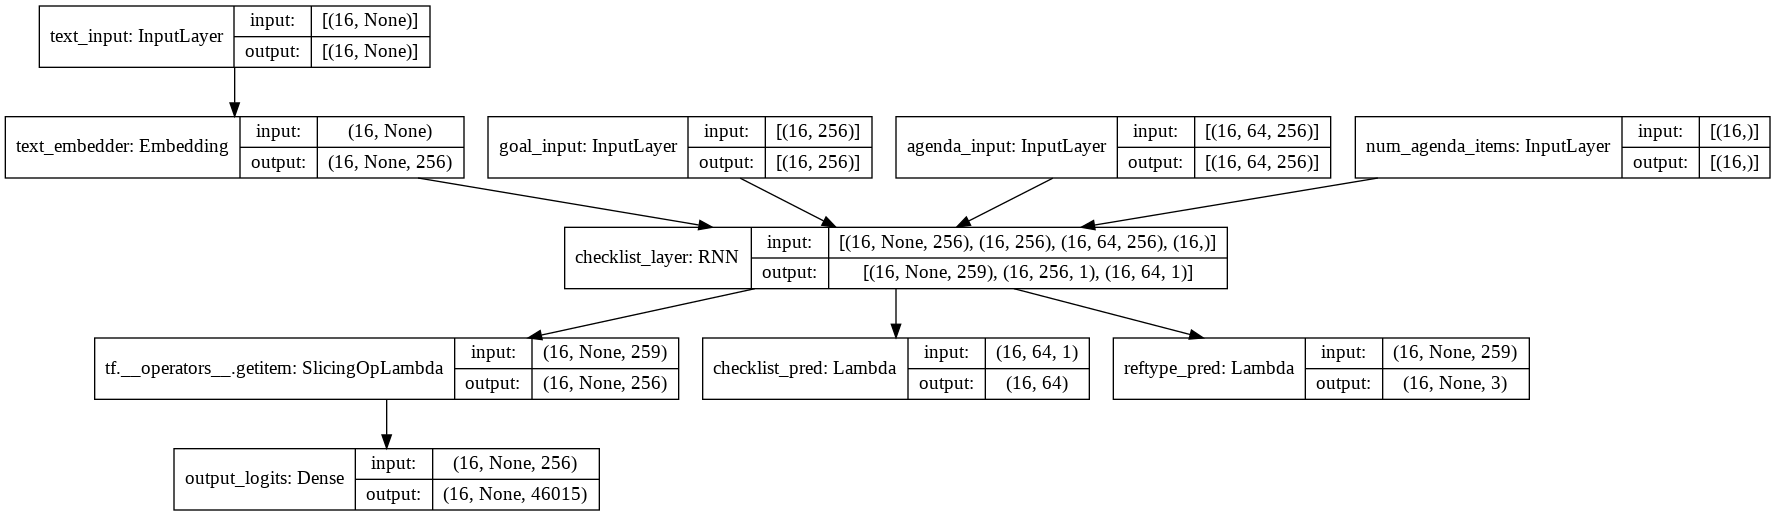

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions[0].shape)

(16, 537, 46015)


In [ ]:
def loss(labels, logits):
    scce = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return scce
    
example_batch_loss = loss(target_example_batch[0], example_batch_predictions[0])
prediction_shape = example_batch_predictions[0].shape
scalar_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", prediction_shape)
print("Loss shape:       ", example_batch_loss.shape)
print("scalar_loss:      ", scalar_loss)
print("exp(scalar_loss): ", np.exp(scalar_loss))
print("vocab size      : ", vocab_size)
print("If all went right, exp(scalar loss) should be approximately equal to vocab size")

Prediction shape:  (16, 537, 46015)
Loss shape:        (16, 537)
scalar_loss:       1.2513896
exp(scalar_loss):  3.4951966
vocab size      :  46015
If all went right, exp(scalar loss) should be approximately equal to vocab size


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Create a checkpoints directory.
checkpoint_dir = os.path.join(CACHE_DIR, MODEL_NAME)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'ckpt_{epoch}'),
    save_weights_only=True
)

In [ ]:
def restore_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Checkpoint not found')
        return model, 0

    print("Checkpoint found")
    print('Path:', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('Name:', latest_checkpoint_name)

    latest_epoch = latest_checkpoint_name.split('_')[-1]
    print('Epoch:', latest_epoch)

    return model, int(latest_epoch)

In [ ]:
TOTAL_EPOCHS = 3
STEPS_PER_EPOCH = 1500

model, initial_epoch = restore_checkpoint(model)

Checkpoint found
Path: ./drive/Shared drives/Capstone/tmp/checklist_attempt_53_gru_returnseq/ckpt_3
Name: ckpt_3
Epoch: 3


In [ ]:
# n/g: 13.763522376777704
# u/g: 21.478057975163356

class ReftypeLoss(keras.losses.Loss):
    def __init__(self):
        self.new_per_gru = 55.42723820892349
        self.used_per_gru = 88.77655755615147 # 21.478057975163356
        self.weights = tf.constant([[
            1,
            self.new_per_gru,
            self.used_per_gru
        ]], dtype=tf.float32)
        super(ReftypeLoss, self).__init__()
    
    
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.reduce_mean(tf.multiply(self.weights, tf.square(y_true - y_pred)), axis=-1)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                       clipnorm=5.0,
                                       clipvalue=5.0),
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        tf.keras.losses.MeanAbsoluteError(),
        ReftypeLoss(),
        tf.keras.losses.MeanAbsoluteError(),
    ],
    loss_weights=[1, 0, 0, 0]
)

In [ ]:
history = model.fit(
    x=dataset,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=initial_epoch,
    verbose=True,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = os.path.join(CACHE_DIR, MODEL_NAME, f'{MODEL_NAME}.h5')
model.save(model_name, save_format='h5')

Epoch 1/3
1500/1500 [==============================] - 3178s 2s/step - loss: 1.4462 - output_logits_loss: 1.4462 - checklist_pred_loss: 0.8501 - reftype_pred_loss: 27.3023 - contrib_norm_loss: 25.0681
Epoch 2/3
1500/1500 [==============================] - 3134s 2s/step - loss: 1.1538 - output_logits_loss: 1.1538 - checklist_pred_loss: 0.8523 - reftype_pred_loss: 29.5081 - contrib_norm_loss: 28.1082
Epoch 3/3
1500/1500 [==============================] - 3130s 2s/step - loss: 1.2935 - output_logits_loss: 1.2935 - checklist_pred_loss: 0.8285 - reftype_pred_loss: 28.5195 - contrib_norm_loss: 26.6088


# Predictions

In [ ]:
# Restore latest checkpoint and change batch to 1
model = build_checklist_model(
    vocab_size=vocab_size, # okay
    embed_dim=EMBED_DIM,
    agenda_items=AGENDA_ITEMS,
    cl_temperature=CL_TEMPERATURE,
    batch_size=1 # ONLINE LEARNING   
)
model, _ = restore_checkpoint(model)
model.build(tf.TensorShape([1, None]))

checklist_output shape (1, None, 263)
output features shape (1, None, 256)
hidden state shape    (1, 256, 1)
checklist_pred shape  (1, 64, 1)
Checkpoint found
Path: ./drive/Shared drives/Capstone/tmp/checklist_attempt_53_gru_returnseq/ckpt_3
Name: ckpt_3
Epoch: 3


In [ ]:
def clean_up_ingredients_for_inference(ingredients):
    return flatten([IngrProc.cleanup_ingredient(ingredient) for ingredient in ingredients])

clean_up_ingredients_for_inference(['4 skinless, boneless chicken breast halves',
           '2 tablespoons butter',
           '2 (10.75 ounce) cans condensed cream of chicken soup',
           '1 onion, finely diced',
           '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces'])

['chicken breast halves',
 'butter',
 'condensed cream',
 'chicken soup',
 'onion',
 'dough']

In [ ]:
# from tqdm import tqdm

def generate_recipe(model, title, ingrs, start_string, verbose=False, num_generate=1000, temperature=0.8):
    # TITLE_START = "🥣" # "🍴 "
    TITLE_START = "🍴 " + title + "\n\n🥑\n• " + "\n• ".join(ingrs) + "\n\n🥣\n"
    # Evaluation step (generating text using the learned model)

    emb_title = tf.expand_dims(convert_and_embed_title(title), 0)
    clean_ingrs = clean_up_ingredients_for_inference(ingrs)
    emb_ingrs = tf.expand_dims(extend_convert_and_embed_ingrs(clean_ingrs, AGENDA_ITEMS), 0)
    
    num_ingrs = tf.expand_dims(tf.constant(len(ingrs)), 0)

    padded_start_string = separate_punct(TITLE_START + start_string)

    tokenized_string = tokenizer.texts_to_sequences([padded_start_string])

    # Converting our start string to numbers (vectorizing).
    input_eval = tf.constant(tokenized_string, dtype=tf.int32)

    # Empty string to store our results.
    # text_generated = []

    # Here batch size == 1
    model.reset_states()

    # iter_range = tqdm(range(num_generate)) if verbose else range(num_generate)
    for i in range(num_generate):
        predictions, checklist_pred, reftype_pred, contrib_norm = model(
            (emb_title, emb_ingrs, num_ingrs, input_eval)
        )
        # print(predictions.shape)

        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the token returned by the model
        predictions = predictions / temperature

        sampled_prediction = tf.random.categorical(predictions, num_samples=1)
        # print(sampled_prediction)
        predicted_id = sampled_prediction[-1,0].numpy()

        if predicted_id == 0: # stop if we start generating the padding token
            break

        # Pass the predicted word as the next input to the model
        # along with the previous hidden state
        tokenized_string[0].append(predicted_id)
        input_eval = tf.constant(tokenized_string[-SEQ_LENGTH:], dtype=tf.int32)
        # print(input_eval)

        if verbose:
            reftype_chosen = ['GRU ', 'NEW ', 'USED'][np.argmax(reftype_pred[0][-1].numpy())]
            print(f"{i}.", reftype_chosen, contrib_norm[0][-1].numpy(), idx2word[predicted_id]) 

        # input_eval = tf.concat([input_eval, tf.expand_dims([predicted_id], 0)], axis=1)
        # text_generated.append(idx2word[predicted_id])
    
    if verbose:
        print("checklist_pred:", checklist_pred)
    
    text_generated = [idx2word[x] for x in input_eval[0].numpy()]

    return (start_string + ' '.join(text_generated))

In [ ]:
generated_text = generate_recipe(
    model,
    title='Slow Cooker Chicken and Dumplings',
    ingrs=['4 skinless, boneless chicken breast halves',
           '2 tablespoons butter',
           '2 (10.75 ounce) cans condensed cream of chicken soup',
           '1 onion, finely diced',
           '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces'],
    start_string='',
    verbose=True,
    num_generate=100,
    temperature=1.0,
)
print("\n" + generated_text)

Pos. 0: USED [ 4.694949  23.88536   30.629906   4.3898454] ‣
Pos. 1: USED [ 3.8261302 23.797808  29.246246   4.4935174] preheat
Pos. 2: USED [ 4.4386215 23.790985  29.604666   4.5096197] the
Pos. 3: USED [ 4.180745  23.263365  30.395504   4.4035788] oven
Pos. 4: USED [ 3.8057742 21.262712  29.624002   4.111597 ] to
Pos. 5: USED [ 4.143203  21.38457   29.47721    3.8330283] 375
Pos. 6: USED [ 2.9103515 20.499046  28.948105   3.6110492] degrees
Pos. 7: USED [ 2.8721597 22.421656  29.060524   3.2975397] f
Pos. 8: USED [ 3.1212668 22.648867  28.630884   3.085341 ] .
Pos. 9: USED [ 5.9909987 23.07312   29.17326    2.86133  ] 

Pos. 10: USED [ 4.694949  23.532156  29.302315   2.8234947] ‣
Pos. 11: USED [ 3.8261302 23.268322  28.691217   2.813292 ] in
Pos. 12: USED [ 3.936365  23.046318  29.351515   2.5183988] oven
Pos. 13: USED [ 3.8057742 21.432302  29.047977   2.593875 ] oven
Pos. 14: USED [ 3.8057742 21.511927  29.281849   2.410481 ] to
Pos. 15: USED [ 4.143203  21.844929  29.375624   2.2

In [ ]:
generated_text = generate_recipe(
    model,
    title='The Best Rolled Sugar Cookies',
    ingrs=['1 1/2 cups butter, softened',
           '2 cups white sugar',
           '4 eggs',
           '1 teaspoon vanilla extract',
           '5 cups all-purpose flour',
           '2 teaspoons baking powder',
           '1 teaspoon salt'],
    start_string='',
    verbose=True,
    num_generate=100,
    temperature=1.0,
)
print("\n" + generated_text)

Pos. 0: USED [ 4.694949 24.051476 25.018242 11.981626] ‣
Pos. 1: USED [ 3.8261302 23.778746  24.11333   11.274539 ] whisk
Pos. 2: GRU  [ 4.2593346 22.876156  24.464943  11.33372  ] all
Pos. 3: GRU  [ 3.9416795 21.820969  23.44064   10.811135 ] of
Pos. 4: USED [ 3.5079925 22.041794  24.438795  11.038333 ] milk
Pos. 5: USED [ 2.3588579 22.336044  23.533726  11.228614 ] ,
Pos. 6: USED [ 4.206535 22.777052 23.150639 11.124226] flour
Pos. 7: USED [ 3.696509 22.373707 23.169329 11.552806] and
Pos. 8: USED [ 3.7680297 22.230007  23.278532  11.0498905] baking
Pos. 9: USED [ 3.4648871 22.601149  23.662731  10.884881 ] powder
Pos. 10: USED [ 2.2466333 22.293804  23.628298  11.216192 ] together
Pos. 11: USED [ 3.0136707 22.67949   23.15668   11.554137 ] in
Pos. 12: USED [ 3.936365  22.92074   22.889418  11.8755455] confectioners
Pos. 13: USED [ 4.768634 22.886915 23.737955 11.473587] .
Pos. 14: USED [ 5.9909987 23.638968  23.339952  10.970672 ] butter
Pos. 15: USED [ 2.8407435 23.696766  23.94730

In [ ]:
generated_text = generate_recipe(
    model,
    title='Slow Cooker Chicken',
    ingrs=['chicken',
           'onion',
           'salt',
           'pepper'],
    start_string='‣ ',
    num_generate=100,
    temperature=0.7
)
print("\n" + generated_text)

 80%|████████  | 80/100 [00:25<00:11,  1.73it/s]


‣ clings wrap cake wrap in hot wrap to greased baking dish and refrigerate for about 15 hours ‣ lightly salted water bake for lightly grease for cooking grill and let stand for 45 to 40 minutes drain and allow off the grill for lightly grease any fat top the vegetables and surface wrap any wrap ‣ place the butter and oil the olive oil top and turn on greased floured surface grill for butter bake for 15 to 40 minutes


In [ ]:
generated_text = generate_recipe(
    model,
    title='Slow Cooker Chicken',
    ingrs=['chicken',
           'onion',
           'salt',
           'pepper'],
    start_string='‣ ',
    num_generate=50,
    temperature=0.8
)
print(generated_text)

‣ anyone's onion chicken salmon peaches and sugar ‣ bake dough on roasting grill grill grill for the grate return pans bake for room rack about 10 minutes cool completely on each side remove potatoes from and lightly wrap bacon breasts on each surface spread well wrap bake for 40 hours


In [ ]:
generated_text = generate_recipe(
    model,
    title='Homemade Mac and Cheese Casserole',
    ingrs=['8 ounces whole wheat rotini pasta',
           '3 cups fresh broccoli florets',
           '1 medium onion, chopped',
           '3 cloves garlic, minced'],
    start_string='',
    num_generate=200,
    temperature=0.9
)
print(generated_text)

🍴 homemade mac and cheese casserole 
 
 🥑 
 • 8 ounces whole wheat rotini pasta 
 • 3 cups fresh broccoli florets 
 • 1 medium onion , chopped 
 • 3 cloves garlic , minced 
 
 🥣 
 ‣ watch how to make this recipe . 
 ‣ soak the spaghetti directly from the oven for the pot positioned to maintain the boil . remove them from the skin and rinse under cold running water . set aside . 
 ‣ heat the olive oil in a whisk the worcestershire sauce , and add in a slow stream . cook , whisking until the mixture is evenly . add the eggs and place a sealed container and cook until a golden brown and the pieces are hot throughout .


## Beam Search

In [ ]:
# Restore latest checkpoint and change batch to 1
model = build_checklist_model(
    vocab_size=vocab_size, # okay
    embed_dim=EMBED_DIM,
    agenda_items=AGENDA_ITEMS,
    cl_temperature=CL_TEMPERATURE,
    batch_size=10 # ONLINE LEARNING   
)
model, _ = restore_checkpoint(model)
model.build(tf.TensorShape([10, None]))

checklist_output shape (10, None, 263)
output features shape (10, None, 256)
hidden state shape    (10, 256, 1)
checklist_pred shape  (10, 64, 1)
Checkpoint found
Path: ./drive/Shared drives/Capstone/tmp/checklist_attempt_53_gru_returnseq/ckpt_3
Name: ckpt_3
Epoch: 3


In [ ]:
def generate_recipe_beam(model, title, ingrs, start_string, beam_width=10, num_generate=1000, temperature=0.8):
    # TITLE_START = "🥣" # "🍴 "
    TITLE_START = "🍴 " + title + "\n\n🥑\n• " + "\n• ".join(ingrs) + "\n\n🥣\n"
    # Evaluation step (generating text using the learned model)

    emb_title = tf.expand_dims(convert_and_embed_title(title), 0)
    clean_ingrs = clean_up_ingredients_for_inference(ingrs)
    emb_ingrs = tf.expand_dims(extend_convert_and_embed_ingrs(clean_ingrs, AGENDA_ITEMS), 0)
    
    num_ingrs = tf.expand_dims(tf.constant(len(ingrs)), 0)

    padded_start_string = separate_punct(TITLE_START + start_string)
    tokenized_string = tokenizer.texts_to_sequences([padded_start_string])[0]

    beams = [(tokenized_string, 0)]
    beams.extend([([0 for _ in tokenized_string], -1e100) for _ in range(beam_width - 1)])

    input_eval = tf.constant(np.array([beam[0] for beam in beams]))

    softmax = tf.keras.layers.Softmax(axis=0)

    # for i in tqdm(range(num_generate)):
    for i in range(num_generate):
        predictions, checklist_pred, reftype_pred, contrib_norm = model((emb_title, emb_ingrs, num_ingrs, input_eval))
        predictions = predictions / temperature
        softmaxed_preds = softmax(predictions)
        beam_cands = []
        for i in range(beam_width):
            beam = beams[i]
            best_pred_ids = sorted(list(enumerate(softmaxed_preds[i].numpy())), key=lambda x: x[1], reverse=True)[:beam_width]
            for pred_id in best_pred_ids:
                beam_cands.append( (beam[0] + [pred_id[0]], beam[1] + np.log(pred_id[1])) )
        beams = sorted(beam_cands, key=lambda x: x[1], reverse=True)[:beam_width]
        input_eval = tf.constant(np.array([beam[0] for beam in beams]))

    for index, beam in enumerate(beams):
        print("Beam ", index, ' '.join([idx2word[x] for x in beam[0]]), beam[1])

    text_generated = [idx2word[x] for x in beam[0]]

    return (start_string + ' '.join(text_generated))

In [ ]:
generated_text = generate_recipe_beam(
    model,
    title='Slow Cooker Chicken',
    ingrs=['chicken',
           'onion',
           'salt',
           'pepper'],
    start_string='‣ ',
    num_generate=50,
    temperature=0.7,
    beam_width=10
)
print("\n" + generated_text)

ValueError: ignored

In [ ]:
recipes[50000]

'🍴 Miniature Crab Cakes with Tomato Ginger Jam \n\n🥑\n• 1/2 cup mayonnaise\n• 1 large egg\n• 1 tablespoon Dijon mustard\n• 3/4 teaspoon Old Bay Seasoning\n• 1 1/2 teaspoons fresh lemon juice\n• 1/4 teaspoon salt\n• 1/8 teaspoon black pepper\n• 1/8 teaspoon Tabasco\n• 1 lb jumbo lump crabmeat, picked over\n• 4 cups cornflakes\n• Accompaniment: tomato ginger jam\n• Garnish: thinly sliced fresh cilantro\n\n🥣\n‣ Whisk together mayonnaise, egg, mustard, Old Bay, lemon juice, salt, pepper, and Tabasco, then gently stir in crabmeat. Chill, covered, 2 hours. Pulse cornflakes in a food processor until coarsely ground and put in a shallow dish. Form 1 heaping teaspoon crab mixture into a 1 1/2-inch-diameter cake (mixture will be very moist), then gently dredge in cornflakes. Make more crab cakes in same manner, transferring to buttered baking sheets. Chill, covered, at least 1 hour. Preheat oven to 400°F. Bake crab cakes in batches in middle of oven until crisp and golden, 8 to 10 minutes. Trans

### Silly statistics things

In [ ]:
total_reftype_counts = tf.zeros((3,))
for index, recipe in tqdm(df_recipes.iterrows()):
    token_instrs = extend_instrs(recipe['token_instrs'])
    ingrs = recipe['ingredients']
    reftype_history = get_reftype_history(ingrs, token_instrs)
    reftype_counts = tf.reduce_sum(reftype_history, axis=0)
    total_reftype_counts += reftype_counts

total_reftype_counts

105789it [01:47, 987.05it/s]


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([50055064.,   903077.,   563832.], dtype=float32)>

In [ ]:
# gru: 12454460 NOT 42203980
# new: 904889
# used: 579869

gru_refs = 50055064 # 12454460
new_refs = 903077 # 904889
used_refs = 563832 # 579869

In [ ]:
print("n/g:", gru_refs / new_refs)
print("u/g:", gru_refs / used_refs)

n/g: 55.42723820892349
u/g: 88.77655755615147


In [ ]:
total_reftype_counts = tf.zeros((3,))
for index, recipe in tqdm(df_recipes.iterrows()):
    token_instrs = np.array(recipe['token_instrs'][0])
    ingrs = recipe['ingredients']
    reftype_history = get_reftype_history(ingrs, token_instrs)
    reftype_counts = tf.reduce_sum(reftype_history, axis=0)
    total_reftype_counts += reftype_counts

total_reftype_counts



0it [00:00, ?it/s]

103it [00:00, 1025.51it/s]

290it [00:00, 1185.86it/s]

472it [00:00, 1323.75it/s]

643it [00:00, 1419.71it/s]

816it [00:00, 1499.26it/s]

988it [00:00, 1558.51it/s]

1158it [00:00, 1596.63it/s]

1335it [00:00, 1642.59it/s]

1516it [00:00, 1688.22it/s]

1688it [00:01, 1694.54it/s]

1863it [00:01, 1708.50it/s]

2035it [00:01, 1709.40it/s]

2211it [00:01, 1724.18it/s]

2384it [00:01, 1713.08it/s]

2556it [00:01, 1697.10it/s]

2729it [00:01, 1705.19it/s]

2900it [00:01, 1698.74it/s]

3073it [00:01, 1707.17it/s]

3249it [00:01, 1722.48it/s]

3422it [00:02, 1717.95it/s]

3594it [00:02, 1708.58it/s]

3771it [00:02, 1723.81it/s]

3945it [00:02, 1725.77it/s]

4128it [00:02, 1753.37it/s]

4317it [00:02, 1791.35it/s]

4497it [00:02, 1789.49it/s]

4677it [00:02, 1770.86it/s]

4855it [00:02, 1769.03it/s]

5033it [00:02, 1762.04it/s]

5210it [00:03, 1749.02it/s]

5389it [00:03, 1758.66it/s]

5577it [00:03, 1790.55it/s]

5757it [00:03, 1761.36it/s]

5934it [00:03, 1754.42it/s]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([12454460.,   904889.,   579869.], dtype=float32)>

In [ ]:
np.argmin([len(recipe) for recipe in encoded_recipes])

42388

In [ ]:
[idx2word[id] for id in encoded_recipes[42388]]

['🍴', 'fish', 'stock', '🥑', '🥣']

## Hierarchical generation.

Use the title+ingredients from rnn_word_emoji_ingr_online.

In [ ]:
# Set to True for generating recipes for evaluation
GENERATE_EVAL_RECIPES = True

In [ ]:
if GENERATE_EVAL_RECIPES:
    title_ingr_dir_path = os.path.join(CACHE_DIR, "rnn_word_emoji_online_title_prompt_ingrs")
    eval_output_dir = os.path.join(CACHE_DIR, "checklist_53_rnn_prompt_recipes")
    pathlib.Path(eval_output_dir).mkdir(exist_ok=True)

    # Generate N recipes using the title+ingredients as input.
    n = 0
    N = 50

    used_titles = []
    for i in tqdm(range(n, N)):
        title_ingr_path = os.path.join(title_ingr_dir_path, f"rnn_word_title_ingr_{i}.txt")
        with open(title_ingr_path, 'r') as f:
            contents = f.read()
        title, ingr_str = contents.split('🥑', 1)
        ingr_str = ingr_str.replace('🥑', '')
        used_titles.append(title)
        ingrs = [ingr for ingr in ingr_str.split(' • ') if ingr][:AGENDA_ITEMS]
        r = generate_recipe(
            model,
            title,
            ingrs,
            start_string='',
            verbose=False,
            num_generate=200,
            temperature=0.9
        )
        
        output_file_name = os.path.join(eval_output_dir, f"checklist_rnn_prompt_recipe_{i}.txt")
        with open(output_file_name, 'w') as f:
            f.write(r)
        
    # Save used titles for later reference
    title_list_file = os.path.join(eval_output_dir, f"titles.txt")
    with open(title_list_file, 'w+') as f:
        f.writelines("%s\n" % t for t in used_titles)

100%|██████████| 50/50 [00:02<00:00, 21.56it/s]


In [ ]:
recipe_strs = recipes.values.tolist()

In [ ]:
if GENERATE_EVAL_RECIPES:
    # title_ingr_dir_path = os.path.join(CACHE_DIR, "rnn_word_emoji_online_title_prompt_ingrs")
    eval_output_dir = os.path.join(CACHE_DIR, "checklist_53_truth_prompt_recipes")
    pathlib.Path(eval_output_dir).mkdir(exist_ok=True)

    # Generate N recipes using the title+ingredients as input.
    n = 0
    N = 50

    used_titles = []
    for i in tqdm(range(n, N)):
        # title_ingr_path = os.path.join(title_ingr_dir_path, f"rnn_word_title_ingr_{i}.txt")
        # with open(title_ingr_path, 'r') as f:
        #     contents = f.read()
        # title, ingr_str = contents.split('🥑', 1)
        # ingr_str = ingr_str.replace('🥑', '')
        recipe_str = random.choice(recipe_strs)
        _, title, ingrs, _ = re.split("🍴|🥑|🥣", recipe_str)
        
        used_titles.append(title)
        ingrs = [ingr for ingr in ingrs.split(' • ') if ingr][:AGENDA_ITEMS]
        r = generate_recipe(
            model,
            title,
            ingrs,
            start_string='',
            verbose=False,
            num_generate=200,
            temperature=0.9
        )
        
        output_file_name = os.path.join(eval_output_dir, f"checklist_truth_prompt_recipe_{i}.txt")
        with open(output_file_name, 'w') as f:
            f.write(r)
        
    # Save used titles for later reference
    title_list_file = os.path.join(eval_output_dir, f"titles.txt")
    with open(title_list_file, 'w+') as f:
        f.writelines("%s\n" % t for t in used_titles)



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [05:31<4:30:48, 331.59s/it]

  4%|▍         | 2/50 [07:47<3:38:12, 272.76s/it]

  6%|▌         | 3/50 [15:38<4:20:26, 332.48s/it]

  8%|▊         | 4/50 [17:54<3:29:38, 273.45s/it]

 10%|█         | 5/50 [19:39<2:47:07, 222.83s/it]

 12%|█▏        | 6/50 [24:21<2:56:21, 240.49s/it]

 14%|█▍        | 7/50 [30:59<3:26:24, 288.00s/it]

 16%|█▌        | 8/50 [35:12<3:14:09, 277.37s/it]

 18%|█▊        | 9/50 [40:38<3:19:30, 291.97s/it]

 20%|██        | 10/50 [42:51<2:42:51, 244.29s/it]

 22%|██▏       | 11/50 [45:34<2:22:51, 219.79s/it]

 24%|██▍       | 12/50 [46:28<1:47:49, 170.25s/it]

 26%|██▌       | 13/50 [48:48<1:39:14, 160.94s/it]

 28%|██▊       | 14/50 [53:13<1:55:20, 192.23s/it]

 30%|███       | 15/50 [58:42<2:16:02, 233.22s/it]

 32%|███▏      | 16/50 [1:02:42<2:13:23, 235.40s/it]

 34%|███▍      | 17/50 [1:09:27<2:37:22, 286.15s/it]

 36%|███▌      | 18/50 [1:14:00<2:30:37, 282.43s/it]

 38%|███▊      | 19/50 [1

In [ ]:
_, title, ingrs, instrs = re.split("🍴|🥑|🥣", random.choice(recipes))

In [ ]:
recipes.values.tolist()

['🍴 Slow Cooker Chicken and Dumplings \n  \n 🥑 \n • 4 skinless ,  boneless chicken breast halves \n • 2 tablespoons butter \n • 2  ( 10 . 75 ounce )  cans condensed cream of chicken soup \n • 1 onion ,  finely diced \n • 2  ( 10 ounce )  packages refrigerated biscuit dough ,  torn into pieces \n  \n 🥣 \n ‣ Place the chicken ,  butter ,  soup ,  and onion in a slow cooker ,  and fill with enough water to cover .  \n ‣ Cover ,  and cook for 5 to 6 hours on High .  About 30 minutes before serving ,  place the torn biscuit dough in the slow cooker .  Cook until the dough is no longer raw in the center . ',
 '🍴 Awesome Slow Cooker Pot Roast \n  \n 🥑 \n • 2  ( 10 . 75 ounce )  cans condensed cream of mushroom soup \n • 1  ( 1 ounce )  package dry onion soup mix \n • 1 1/4 cups water \n • 5 1/2 pounds pot roast \n  \n 🥣 \n ‣ In a slow cooker ,  mix cream of mushroom soup ,  dry onion soup mix and water .  Place pot roast in slow cooker and coat with soup mixture .  \n ‣ Cook on High setting f